In [483]:
## import of libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from IPython.core.pylabtools import figsize

# additional tools needed
from re import match
from functools import reduce

## models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# sklearn additional libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mutual_info_score
from sklearn.metrics import roc_auc_score

# for Hypterparameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In this project, we're gonna classify if Radiant or Dire would be the winner using several features.
This will focus on a Pre-game Classifier

# DOTA 2 RADIANT OR DIRE?
To predict which team is gonna win before the game begins, we're gonna check and use the following features:
* Day_of_Week
* TimeHour
* Region
* Dire vs Radiant:
    - Heroes Selected
    - Winrate of players
    - TrueSkill of players


## Data Preparation

In [484]:
import os
from os.path import join

source_folder = './datasource'

# Import all the csv files and save the filenames to datasets
available_datasets = dict([(path[:-4], path) for path in os.listdir(source_folder) if path[-4:] == '.csv'])
available_datasets = dict(sorted(available_datasets.items()))

In [485]:
available_datasets

{'ability_ids': 'ability_ids.csv',
 'ability_upgrades': 'ability_upgrades.csv',
 'chat': 'chat.csv',
 'cluster_regions': 'cluster_regions.csv',
 'hero_names': 'hero_names.csv',
 'item_ids': 'item_ids.csv',
 'match': 'match.csv',
 'match_outcomes': 'match_outcomes.csv',
 'objectives': 'objectives.csv',
 'patch_dates': 'patch_dates.csv',
 'player_ratings': 'player_ratings.csv',
 'player_time': 'player_time.csv',
 'players': 'players.csv',
 'purchase_log': 'purchase_log.csv',
 'teamfights': 'teamfights.csv',
 'teamfights_players': 'teamfights_players.csv',
 'test_labels': 'test_labels.csv',
 'test_player': 'test_player.csv'}

In [486]:
# Import the only needed csv files
cluster_regions_dataset = pd.read_csv(source_folder + '/' + 'cluster_regions.csv')
hero_names_dataset = pd.read_csv(source_folder + '/' + 'hero_names.csv')
match_dataset = pd.read_csv(source_folder + '/' + 'match.csv')
player_ratings_dataset = pd.read_csv(source_folder + '/' + 'player_ratings.csv')
players_dataset = pd.read_csv(source_folder + '/' + 'players.csv')

To achieve the desired dataset, 4 sub-datasets will be prepared
* match_dataset
* player_ratings_dataset
* players_dataset
* hero_name

### Data Sources

**Match Details**

In [487]:
match_dataset.head()

,match_id,start_time,duration,tower_status_radiant,tower_status_dire,barracks_status_dire,barracks_status_radiant,first_blood_time,game_mode,radiant_win,negative_votes,positive_votes,cluster
0,0,1446750112,2375,1982,4,3,63,1,22,True,0,1,155
1,1,1446753078,2582,0,1846,63,0,221,22,False,0,2,154
2,2,1446764586,2716,256,1972,63,48,190,22,False,0,0,132
3,3,1446765723,3085,4,1924,51,3,40,22,False,0,0,191
4,4,1446796385,1887,2047,0,0,63,58,22,True,0,0,156


In [488]:
# Select the needed columns only
match_details = match_dataset[['match_id','start_time','game_mode','cluster','radiant_win']]
match_details

,match_id,start_time,game_mode,cluster,radiant_win
0,0,1446750112,22,155,True
1,1,1446753078,22,154,False
2,2,1446764586,22,132,False
3,3,1446765723,22,191,False
4,4,1446796385,22,156,True
...,...,...,...,...,...
49995,49995,1447829192,22,111,True
49996,49996,1447829181,22,204,True
49997,49997,1447829197,22,111,True
49998,49998,1447829189,22,151,True


In [489]:
# Check if match_ids are unique in the dataset
match_details.match_id.is_unique

True

In [490]:
# Check the unique values of target variable 'radiant_win'
match_details['radiant_win'].unique()

array([ True, False])

True - Radiant Win \
False - Dire Win

In [491]:
# Check if there are null values in match_details
match_details.isna().sum()

match_id       0
start_time     0
game_mode      0
cluster        0
radiant_win    0
dtype: int64

In [492]:
match_details = pd.merge(match_details, cluster_regions_dataset, on ='cluster')
match_details = match_details.reset_index(drop=True)

del match_details['cluster']
match_details

,match_id,start_time,game_mode,radiant_win,region
0,0,1446750112,22,True,SINGAPORE
1,5,1446798766,22,True,SINGAPORE
2,29,1446910512,22,False,SINGAPORE
3,32,1446917368,22,True,SINGAPORE
4,34,1446919403,22,True,SINGAPORE
...,...,...,...,...,...
49995,28787,1447608679,22,False,DUBAI
49996,36032,1447683459,22,False,DUBAI
49997,36287,1447686751,22,True,DUBAI
49998,36584,1447690241,22,True,DUBAI


Checking on the start time, we are interested in the:
* day of week
* time of day

In [493]:
match_details['date'] = pd.to_datetime(match_details['start_time'],unit='s')
match_details['day_of_week'] = match_details['date'].dt.day_name()
match_details['time'] = match_details['date'].dt.strftime('%H:%M')
match_details['time'] = match_details['time'].str[:2].astype(int)

del match_details['start_time']
del match_details['date']

In [494]:
match_details

,match_id,game_mode,radiant_win,region,day_of_week,time
0,0,22,True,SINGAPORE,Thursday,19
1,5,22,True,SINGAPORE,Friday,8
2,29,22,False,SINGAPORE,Saturday,15
3,32,22,True,SINGAPORE,Saturday,17
4,34,22,True,SINGAPORE,Saturday,18
...,...,...,...,...,...,...
49995,28787,22,False,DUBAI,Sunday,17
49996,36032,22,False,DUBAI,Monday,14
49997,36287,22,True,DUBAI,Monday,15
49998,36584,22,True,DUBAI,Monday,16


In [495]:
match_details['day_of_week'].value_counts(normalize=True)

Sunday       0.20912
Saturday     0.18090
Tuesday      0.16354
Monday       0.14930
Friday       0.13766
Thursday     0.11370
Wednesday    0.04578
Name: day_of_week, dtype: float64

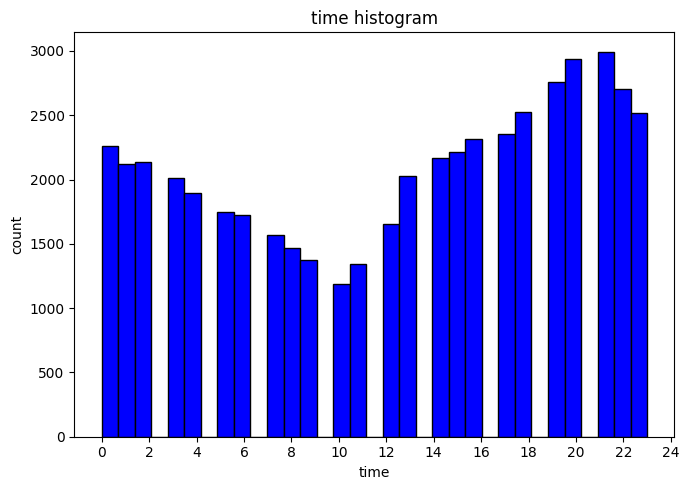

In [496]:
hist_feature = 'time'
dataset = match_details[hist_feature]

# Create histogram
fig = plt.figure(tight_layout=True,
                 figsize=(7, 5)
                )

q25, q75 = np.percentile(dataset, [25, 75])
bin_width = 2 * (q75 - q25) * len(dataset) ** (-1/3)
bins = round((dataset.max() - dataset.min()) / bin_width)

plt.hist(dataset,
         color='blue',
         edgecolor='black',
         bins=bins)
 
plt.xlabel(hist_feature)
plt.ylabel('count')

plt.locator_params(axis='x', nbins=24)
fig.align_labels()

plt.title(hist_feature + ' histogram')

plt.show()

Based from the histogram, we can see that the time of the day with highest count of players is between 2pm to 12 midnight

In [497]:
# Check the frequency of game_modes in the dataset
match_details['game_mode'].value_counts()

# 2 - Captain's Mode
# 22 - Ranked Matchmaking

22    48670
2      1330
Name: game_mode, dtype: int64

In [498]:
match_details['game_mode'].value_counts(normalize=True)

22    0.9734
2     0.0266
Name: game_mode, dtype: float64

Since there's only 2.7% for captain mode games, we will remove it in the features we're gonna model with

In [499]:
del match_details['game_mode']

In [500]:
# Check the frequency of regions in the dataset
match_details['region'].value_counts(normalize=True)

EUROPE                  0.36894
US EAST                 0.21808
SINGAPORE               0.15876
US WEST                 0.07548
AUSTRALIA               0.05028
AUSTRIA                 0.04556
BRAZIL                  0.03656
STOCKHOLM               0.03426
PW TELECOM SHANGHAI     0.00562
PW TELECOM ZHEJIANG     0.00182
PW TELECOM GUANGDONG    0.00180
JAPAN                   0.00176
PW UNICOM               0.00068
DUBAI                   0.00036
CHILE                   0.00004
Name: region, dtype: float64

In [501]:
match_details['region'].value_counts()

EUROPE                  18447
US EAST                 10904
SINGAPORE                7938
US WEST                  3774
AUSTRALIA                2514
AUSTRIA                  2278
BRAZIL                   1828
STOCKHOLM                1713
PW TELECOM SHANGHAI       281
PW TELECOM ZHEJIANG        91
PW TELECOM GUANGDONG       90
JAPAN                      88
PW UNICOM                  34
DUBAI                      18
CHILE                       2
Name: region, dtype: int64

To prevent very small amount of dataset for a given region, we will further regroup the regions

In [502]:
region_dict = {
        'EUROPE':'EMEA',
        'AUSTRIA':'EMEA',
        'STOCKHOLM':'EMEA',
        'DUBAI':'EMEA',
        'US EAST':'Americas',
        'US WEST':'Americas',
        'BRAZIL':'Americas',
        'CHILE': 'Americas',
        'PW TELECOM SHANGHAI': 'Asia',
        'PW TELECOM ZHEJIANG': 'Asia',
        'PW TELECOM GUANGDONG': 'Asia',
        'PW UNICOM': 'Asia',
        'SINGAPORE': 'Asia',
        'AUSTRALIA': 'Asia',
        'JAPAN': 'Asia'
    }

In [503]:
match_details['cluster'] = match_details['region'].map(region_dict)

In [504]:
print(match_details['cluster'].value_counts())
print(match_details['cluster'].value_counts(normalize=True))

EMEA        22456
Americas    16508
Asia        11036
Name: cluster, dtype: int64
EMEA        0.44912
Americas    0.33016
Asia        0.22072
Name: cluster, dtype: float64


In [505]:
match_details

,match_id,radiant_win,region,day_of_week,time,cluster
0,0,True,SINGAPORE,Thursday,19,Asia
1,5,True,SINGAPORE,Friday,8,Asia
2,29,False,SINGAPORE,Saturday,15,Asia
3,32,True,SINGAPORE,Saturday,17,Asia
4,34,True,SINGAPORE,Saturday,18,Asia
...,...,...,...,...,...,...
49995,28787,False,DUBAI,Sunday,17,EMEA
49996,36032,False,DUBAI,Monday,14,EMEA
49997,36287,True,DUBAI,Monday,15,EMEA
49998,36584,True,DUBAI,Monday,16,EMEA


In [506]:
match_ge_info = match_details[['match_id','region','cluster','day_of_week','time','radiant_win']]
match_ge_info = match_ge_info.sort_values(by='match_id').reset_index(drop=True)
match_ge_info

,match_id,region,cluster,day_of_week,time,radiant_win
0,0,SINGAPORE,Asia,Thursday,19,True
1,1,SINGAPORE,Asia,Thursday,19,False
2,2,EUROPE,EMEA,Thursday,23,False
3,3,AUSTRIA,EMEA,Thursday,23,False
4,4,SINGAPORE,Asia,Friday,7,True
...,...,...,...,...,...,...
49995,49995,US WEST,Americas,Wednesday,6,True
49996,49996,BRAZIL,Americas,Wednesday,6,True
49997,49997,US WEST,Americas,Wednesday,6,True
49998,49998,SINGAPORE,Asia,Wednesday,6,True


**match_teamskills & match_winrates**

In [507]:
players_dataset

,match_id,account_id,hero_id,player_slot,gold,gold_spent,gold_per_min,xp_per_min,kills,deaths,assists,denies,last_hits,stuns,hero_damage,hero_healing,tower_damage,item_0,item_1,item_2,item_3,item_4,item_5,level,leaver_status,xp_hero,xp_creep,xp_roshan,xp_other,gold_other,gold_death,gold_buyback,gold_abandon,gold_sell,gold_destroying_structure,gold_killing_heros,gold_killing_creeps,gold_killing_roshan,gold_killing_couriers,unit_order_none,unit_order_move_to_position,unit_order_move_to_target,unit_order_attack_move,unit_order_attack_target,unit_order_cast_position,unit_order_cast_target,unit_order_cast_target_tree,unit_order_cast_no_target,unit_order_cast_toggle,unit_order_hold_position,unit_order_train_ability,unit_order_drop_item,unit_order_give_item,unit_order_pickup_item,unit_order_pickup_rune,unit_order_purchase_item,unit_order_sell_item,unit_order_disassemble_item,unit_order_move_item,unit_order_cast_toggle_auto,unit_order_stop,unit_order_taunt,unit_order_buyback,unit_order_glyph,unit_order_eject_item_from_stash,unit_order_cast_rune,unit_order_ping_ability,unit_order_move_to_direction,unit_order_patrol,unit_order_vector_target_position,unit_order_radar,unit_order_set_item_combine_lock,unit_order_continue
0,0,0,86,0,3261,10960,347,362,9,3,18,1,30,76.7356,8690,218,143,180,37,73,56,108,0,16,0,8840.0,5440.0,NaN,83.0,50.0,-957.0,NaN,NaN,212.0,3120.0,5145.0,1087.0,400.0,NaN,NaN,4070.0,1.0,25.0,416.0,51.0,144.0,3.0,71.0,NaN,188.0,16.0,NaN,NaN,NaN,2.0,35.0,2.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,51,1,2954,17760,494,659,13,3,18,9,109,87.4164,23747,0,423,46,63,119,102,24,108,22,0,14331.0,8440.0,2683.0,671.0,395.0,-1137.0,NaN,NaN,1650.0,3299.0,6676.0,4317.0,937.0,NaN,NaN,5894.0,214.0,165.0,1031.0,98.0,39.0,4.0,439.0,NaN,346.0,22.0,NaN,NaN,12.0,52.0,30.0,4.0,NaN,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,83,2,110,12195,350,385,0,4,15,1,58,None,4217,1595,399,48,60,59,108,65,0,17,0,6692.0,8112.0,NaN,453.0,259.0,-1436.0,-1015.0,NaN,NaN,3142.0,2418.0,3697.0,400.0,NaN,NaN,7053.0,3.0,132.0,645.0,36.0,160.0,20.0,373.0,NaN,643.0,17.0,5.0,NaN,7.0,8.0,28.0,NaN,1.0,18.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,11,3,1179,22505,599,605,8,4,19,6,271,None,14832,2714,6055,63,147,154,164,79,160,21,0,8583.0,14230.0,894.0,293.0,100.0,-2156.0,NaN,NaN,938.0,4714.0,4104.0,10432.0,400.0,NaN,NaN,4712.0,133.0,163.0,690.0,9.0,15.0,7.0,406.0,NaN,150.0,21.0,NaN,NaN,1.0,9.0,45.0,7.0,NaN,14.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,3,67,4,3307,23825,613,762,20,3,17,13,245,None,33740,243,1833,114,92,147,0,137,63,24,0,15814.0,14325.0,NaN,62.0,NaN,-1437.0,-1056.0,NaN,4194.0,3217.0,7467.0,9220.0,400.0,NaN,NaN,3853.0,7.0,7.0,1173.0,31.0,84.0,8.0,198.0,NaN,111.0,23.0,1.0,NaN,NaN,2.0,44.0,6.0,NaN,13.0,NaN,NaN,NaN,1.0,3.0,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,49999,0,100,128,2718,17735,468,626,16,9,16,2,70,54.4912,22127,0,1227,249,41,0,50,141,168,23,0,21496.0,6025.0,596.0,1007.0,528.0,-4131.0,NaN,NaN,237.0,3860.0,9377.0,2940.0,400.0,NaN,NaN,4042.0,79.0,192.0,423.0,81.0,38.0,5.0,281.0,NaN,NaN,22.0,NaN,NaN,2.0,21.0,32.0,3.0,NaN,9.0,21.0,169.0,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN
499996,49999,0,9,129,3755,20815,507,607,12,6,11,7,115,43.0999,12381,0,2269,135,63,166,30,36,139,23,0,16360.0,9653.0,1490.0,740.0,329.0,-2274.0,NaN,NaN,1587.0,4945.0,8292.0,4346.0,857.0,175.0,NaN,4412.0,NaN,89.0,625.0,75.0,NaN,4.0,162.0,2.0,224.0,21.0,NaN,NaN,NaN,9.0,42.0,7.0,NaN,13.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN
499997,49999,0,90,130,1059,16225,371,404,5,3,11,2,92,18.1353,7050,872,87,79,48,152,108,102,117,18,0,8205.0,10012.0,NaN,600.0,303.0,-1287.0,NaN,NaN,NaN,386

In [508]:
# Players dataset: Get the needed columns only
players = players_dataset[['match_id','account_id','hero_id','player_slot']]
players = players.reset_index(drop=True)
players

,match_id,account_id,hero_id,player_slot
0,0,0,86,0
1,0,1,51,1
2,0,0,83,2
3,0,2,11,3
4,0,3,67,4
...,...,...,...,...
499995,49999,0,100,128
499996,49999,0,9,129
499997,49999,0,90,130
499998,49999,0,73,131


This players dataset can be merge into player_ratings dataset which can be merge later on to match_details

In [509]:
player_ratings_dataset

,account_id,total_wins,total_matches,trueskill_mu,trueskill_sigma
0,236579,14,24,27.868035,5.212361
1,-343,1,1,26.544163,8.065475
2,-1217,1,1,26.521103,8.114989
3,-1227,1,1,27.248025,8.092217
4,-1284,0,1,22.931016,8.092224
...,...,...,...,...,...
834221,-298722891,1,1,27.643145,8.013786
834222,106173,0,1,23.069381,7.998792
834223,312076,1,1,28.217084,7.889176
834224,-299193988,0,2,22.406145,7.851303


In this dataset, we are interested on the:
* winrate (total_wins/total_matches)
* trueskill_mu

In [510]:
# Players Ratings dataset: Get the needed columns only
player_ratings = player_ratings_dataset.copy()
player_ratings['winrate'] = player_ratings['total_wins'] / player_ratings['total_matches'] 

player_ratings = player_ratings[['account_id','winrate','trueskill_mu']]
player_ratings

,account_id,winrate,trueskill_mu
0,236579,0.583333,27.868035
1,-343,1.000000,26.544163
2,-1217,1.000000,26.521103
3,-1227,1.000000,27.248025
4,-1284,0.000000,22.931016
...,...,...,...
834221,-298722891,1.000000,27.643145
834222,106173,0.000000,23.069381
834223,312076,1.000000,28.217084
834224,-299193988,0.000000,22.406145


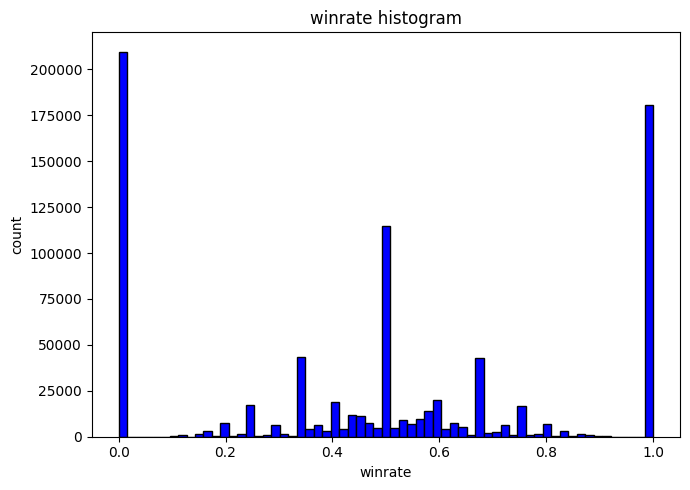

In [511]:
hist_feature = 'winrate'
dataset = player_ratings[hist_feature]

# Create histogram
fig = plt.figure(tight_layout=True,
                 figsize=(7, 5)
                )

q25, q75 = np.percentile(dataset, [25, 75])
bin_width = 2 * (q75 - q25) * len(dataset) ** (-1/3)
bins = round((dataset.max() - dataset.min()) / bin_width)

plt.hist(dataset,
         color='blue',
         edgecolor='black',
         bins=bins)
 
plt.xlabel(hist_feature)
plt.ylabel('count')

plt.locator_params(axis='x', nbins=10)
fig.align_labels()

plt.title(hist_feature + ' histogram')

plt.show()

In [512]:
winrate_freq = player_ratings['winrate'].value_counts(bins = 5).sort_index()
winrate_freq

(-0.002, 0.2]    223552
(0.2, 0.4]       103770
(0.4, 0.6]       220742
(0.6, 0.8]        98166
(0.8, 1.0]       187996
Name: winrate, dtype: int64

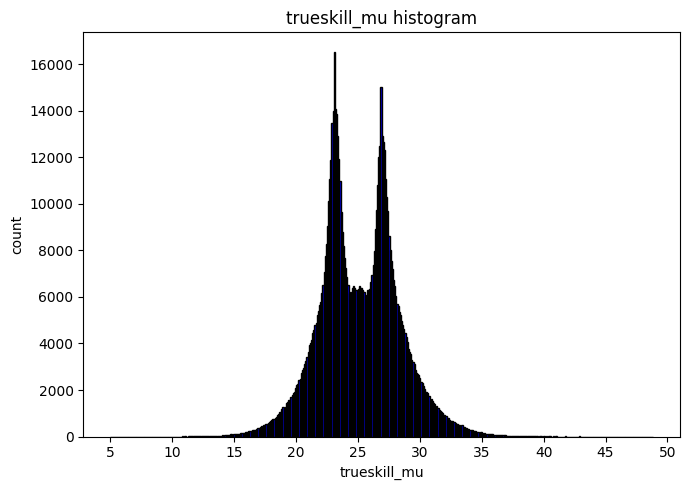

In [513]:
hist_feature = 'trueskill_mu'
dataset = player_ratings[hist_feature]

# Create histogram
fig = plt.figure(tight_layout=True,
                 figsize=(7, 5)
                )

q25, q75 = np.percentile(dataset, [25, 75])
bin_width = 2 * (q75 - q25) * len(dataset) ** (-1/3)
bins = round((dataset.max() - dataset.min()) / bin_width)

plt.hist(dataset,
         color='blue',
         edgecolor='black',
         bins=bins)
 
plt.xlabel(hist_feature)
plt.ylabel('count')

plt.locator_params(axis='x', nbins=10)
fig.align_labels()

plt.title(hist_feature + ' histogram')

plt.show()

In [514]:
trueskill_freq = player_ratings['trueskill_mu'].value_counts(bins = 5).sort_index()
trueskill_freq

(4.949, 13.76]         540
(13.76, 22.526]     162184
(22.526, 31.293]    645538
(31.293, 40.059]     25871
(40.059, 48.826]        93
Name: trueskill_mu, dtype: int64

In order to have some categorization in the player ratings, we will use the ff categorization:
* (4.949, 13.76]    Very Low Skill 
* (13.76, 22.526]   Low Skill 
* (22.526, 31.293]  Normal Skill 
* (31.293, 40.059]  High Skill
* (40.059, 48.826]  Very High Skill 

In [515]:
def get_skillrank(trueskill_mu):
        if trueskill_mu > 40.059:
             return "Very High Skill"
        elif trueskill_mu > 31.293:
             return "High Skill"
        elif trueskill_mu > 22.526:
             return "Normal Skill"
        elif trueskill_mu > 13.76:
             return "Low Skill"
        elif trueskill_mu > 0:
             return "Very Low Skill"
        else:
             return "Unknown"

In [516]:
player_ratings['skillrank'] = player_ratings['trueskill_mu'].apply(get_skillrank)
del player_ratings['trueskill_mu']

In [517]:
player_ratings

,account_id,winrate,skillrank
0,236579,0.583333,Normal Skill
1,-343,1.000000,Normal Skill
2,-1217,1.000000,Normal Skill
3,-1227,1.000000,Normal Skill
4,-1284,0.000000,Normal Skill
...,...,...,...
834221,-298722891,1.000000,Normal Skill
834222,106173,0.000000,Normal Skill
834223,312076,1.000000,Normal Skill
834224,-299193988,0.000000,Low Skill


Combine players and player_ratings dataset

In [518]:
player_stats = pd.merge(players,player_ratings, on = 'account_id')
player_stats = player_stats.sort_values(by=['match_id','player_slot']).reset_index(drop = True)

del player_stats['account_id']
del player_stats['hero_id']

print(player_stats[:20])
player_stats

    match_id  player_slot   winrate     skillrank
0          0            0  0.485178  Normal Skill
1          0            1  0.583333  Normal Skill
2          0            2  0.485178  Normal Skill
3          0            3  0.625000  Normal Skill
4          0            4  0.312500     Low Skill
5          0          128  0.550000  Normal Skill
6          0          129  0.485178  Normal Skill
7          0          130  0.666667    High Skill
8          0          131  0.485178  Normal Skill
9          0          132  0.800000    High Skill
10         1            0  0.485178  Normal Skill
11         1            1  0.589744  Normal Skill
12         1            2  0.485178  Normal Skill
13         1            3  0.291667     Low Skill
14         1            4  0.550000  Normal Skill
15         1          128  0.750000  Normal Skill
16         1          129  0.485178  Normal Skill
17         1          130  0.485178  Normal Skill
18         1          131  0.666667    High Skill


,match_id,player_slot,winrate,skillrank
0,0,0,0.485178,Normal Skill
1,0,1,0.583333,Normal Skill
2,0,2,0.485178,Normal Skill
3,0,3,0.625000,Normal Skill
4,0,4,0.312500,Low Skill
...,...,...,...,...
465873,49999,4,0.718447,Normal Skill
465874,49999,128,0.485178,Normal Skill
465875,49999,129,0.485178,Normal Skill
465876,49999,130,0.485178,Normal Skill


Include Team based on player_slot:
* 0-4: Radiant
* 128-132: Dire

In [519]:
player_stats_new = player_stats.copy()
player_stats_new['team'] = np.where(player_stats_new['player_slot'] <= 4, 'radiant', 'dire')
del player_stats_new['player_slot']

player_stats_new[:20]

,match_id,winrate,skillrank,team
0,0,0.485178,Normal Skill,radiant
1,0,0.583333,Normal Skill,radiant
2,0,0.485178,Normal Skill,radiant
3,0,0.625000,Normal Skill,radiant
4,0,0.312500,Low Skill,radiant
5,0,0.550000,Normal Skill,dire
6,0,0.485178,Normal Skill,dire
7,0,0.666667,High Skill,dire
8,0,0.485178,Normal Skill,dire
9,0,0.800000,High Skill,dire


In [520]:
player_stats_new[player_stats_new['match_id'] == 4]

,match_id,winrate,skillrank,team
37,4,0.485178,Normal Skill,radiant
38,4,0.545455,Normal Skill,radiant
39,4,0.600000,Normal Skill,radiant
40,4,0.625000,Normal Skill,radiant
41,4,0.560000,Normal Skill,radiant
42,4,0.500000,Normal Skill,dire
43,4,0.333333,Normal Skill,dire
44,4,0.485178,Normal Skill,dire
45,4,0.666667,High Skill,dire
46,4,0.600000,Normal Skill,dire


In [521]:
player_stats_ref = player_stats_new.copy()
player_stats_ref['skillrank'] = player_stats_ref['team'] + '_' + player_stats_ref['skillrank'].str.lower()
match_teamskills = player_stats_ref.groupby(['match_id','team'])['skillrank'].aggregate(list).unstack().reset_index()
match_teamskills = match_teamskills[['match_id','radiant','dire']]
match_teamskills.columns = ['match_id','radiant_skills','dire_skills']
match_teamskills.head()

,match_id,radiant_skills,dire_skills
0,0,"[radiant_normal skill, radiant_normal skill, radiant_normal skill, radiant_normal skill, radiant_low skill]","[dire_normal skill, dire_normal skill, dire_high skill, dire_normal skill, dire_high skill]"
1,1,"[radiant_normal skill, radiant_normal skill, radiant_normal skill, radiant_low skill, radiant_normal skill]","[dire_normal skill, dire_normal skill, dire_normal skill, dire_high skill, dire_normal skill]"
2,2,"[radiant_normal skill, radiant_normal skill, radiant_normal skill, radiant_normal skill]","[dire_normal skill, dire_normal skill, dire_normal skill, dire_normal skill, dire_normal skill]"
3,3,"[radiant_normal skill, radiant_normal skill, radiant_normal skill, radiant_low skill]","[dire_normal skill, dire_normal skill, dire_normal skill, dire_low skill]"
4,4,"[radiant_normal skill, radiant_normal skill, radiant_normal skill, radiant_normal skill, radiant_normal skill]","[dire_normal skill, dire_normal skill, dire_normal skill, dire_high skill, dire_normal skill]"


In [522]:
player_stats_ref = player_stats_new.copy()
match_winrates = player_stats_ref.groupby(['match_id','team'])['winrate'].mean().unstack().reset_index().rename_axis(None, axis=1)
match_winrates = match_winrates[['match_id','radiant','dire']]
match_winrates.columns = ['match_id','radiant_winrate','dire_winrate']
match_winrates.head()

,match_id,radiant_winrate,dire_winrate
0,0,0.498238,0.597404
1,1,0.480353,0.574440
2,2,0.871294,0.485178
3,3,0.417589,0.607405
4,4,0.563126,0.517036


**Player Heroes**

In [523]:
# Heroes dataset: Get the needed columns only
heroes_df = hero_names_dataset[['hero_id','localized_name']]
heroes_df = heroes_df.rename(columns={'localized_name': 'hero_name'})
heroes_df = heroes_df.reset_index(drop=True)
hero_lookup = dict(zip(heroes_df['hero_id'], heroes_df['hero_name']))
heroes_df

,hero_id,hero_name
0,1,Anti-Mage
1,2,Axe
2,3,Bane
3,4,Bloodseeker
4,5,Crystal Maiden
...,...,...
107,109,Terrorblade
108,110,Phoenix
109,111,Oracle
110,112,Winter Wyvern


In [524]:
print(heroes_df['hero_name'].values)

['Anti-Mage' 'Axe' 'Bane' 'Bloodseeker' 'Crystal Maiden' 'Drow Ranger'
 'Earthshaker' 'Juggernaut' 'Mirana' 'Morphling' 'Shadow Fiend'
 'Phantom Lancer' 'Puck' 'Pudge' 'Razor' 'Sand King' 'Storm Spirit' 'Sven'
 'Tiny' 'Vengeful Spirit' 'Windranger' 'Zeus' 'Kunkka' 'Lina' 'Lion'
 'Shadow Shaman' 'Slardar' 'Tidehunter' 'Witch Doctor' 'Lich' 'Riki'
 'Enigma' 'Tinker' 'Sniper' 'Necrophos' 'Warlock' 'Beastmaster'
 'Queen of Pain' 'Venomancer' 'Faceless Void' 'Wraith King'
 'Death Prophet' 'Phantom Assassin' 'Pugna' 'Templar Assassin' 'Viper'
 'Luna' 'Dragon Knight' 'Dazzle' 'Clockwerk' 'Leshrac' "Nature's Prophet"
 'Lifestealer' 'Dark Seer' 'Clinkz' 'Omniknight' 'Enchantress' 'Huskar'
 'Night Stalker' 'Broodmother' 'Bounty Hunter' 'Weaver' 'Jakiro'
 'Batrider' 'Chen' 'Spectre' 'Ancient Apparition' 'Doom' 'Ursa'
 'Spirit Breaker' 'Gyrocopter' 'Alchemist' 'Invoker' 'Silencer'
 'Outworld Devourer' 'Lycan' 'Brewmaster' 'Shadow Demon' 'Lone Druid'
 'Chaos Knight' 'Meepo' 'Treant Protector' 'Ogre

Check if hero_ids in players dataset can be found in the heroes dataset

In [525]:
print('players_dataset')
players_hero_ids = players['hero_id'].unique().astype(int)
np.sort(players_hero_ids)

players_dataset


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 109, 110, 111, 112])

In [526]:
print('heroes_dataset')
hero_ids = heroes_df['hero_id'].values
np.sort(hero_ids)

heroes_dataset


array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113])

Since there is no 0 in the heroes dataset but present in players dataset, We will create 0 in the heroes_dataset and lookup

In [527]:
# heroes dataframe
new_heroes_df = heroes_df.copy()

list_row = [0,'Unknown']
new_heroes_df.loc[len(new_heroes_df)] = list_row

new_heroes_df = new_heroes_df.drop_duplicates()
new_heroes_df = new_heroes_df.sort_values(by='hero_id')
new_heroes_df = new_heroes_df.reset_index(drop = True)
new_heroes_df

,hero_id,hero_name
0,0,Unknown
1,1,Anti-Mage
2,2,Axe
3,3,Bane
4,4,Bloodseeker
...,...,...
108,109,Terrorblade
109,110,Phoenix
110,111,Oracle
111,112,Winter Wyvern


In [528]:
# heroes lookup      
new_hero_lookup = list(hero_lookup.items())
new_hero_lookup.insert(0, (0, 'Unkown'))
new_hero_lookup = dict(new_hero_lookup)

new_hero_lookup

{0: 'Unkown',
 1: 'Anti-Mage',
 2: 'Axe',
 3: 'Bane',
 4: 'Bloodseeker',
 5: 'Crystal Maiden',
 6: 'Drow Ranger',
 7: 'Earthshaker',
 8: 'Juggernaut',
 9: 'Mirana',
 10: 'Morphling',
 11: 'Shadow Fiend',
 12: 'Phantom Lancer',
 13: 'Puck',
 14: 'Pudge',
 15: 'Razor',
 16: 'Sand King',
 17: 'Storm Spirit',
 18: 'Sven',
 19: 'Tiny',
 20: 'Vengeful Spirit',
 21: 'Windranger',
 22: 'Zeus',
 23: 'Kunkka',
 25: 'Lina',
 26: 'Lion',
 27: 'Shadow Shaman',
 28: 'Slardar',
 29: 'Tidehunter',
 30: 'Witch Doctor',
 31: 'Lich',
 32: 'Riki',
 33: 'Enigma',
 34: 'Tinker',
 35: 'Sniper',
 36: 'Necrophos',
 37: 'Warlock',
 38: 'Beastmaster',
 39: 'Queen of Pain',
 40: 'Venomancer',
 41: 'Faceless Void',
 42: 'Wraith King',
 43: 'Death Prophet',
 44: 'Phantom Assassin',
 45: 'Pugna',
 46: 'Templar Assassin',
 47: 'Viper',
 48: 'Luna',
 49: 'Dragon Knight',
 50: 'Dazzle',
 51: 'Clockwerk',
 52: 'Leshrac',
 53: "Nature's Prophet",
 54: 'Lifestealer',
 55: 'Dark Seer',
 56: 'Clinkz',
 57: 'Omniknight',
 58

In [529]:
players

,match_id,account_id,hero_id,player_slot
0,0,0,86,0
1,0,1,51,1
2,0,0,83,2
3,0,2,11,3
4,0,3,67,4
...,...,...,...,...
499995,49999,0,100,128
499996,49999,0,9,129
499997,49999,0,90,130
499998,49999,0,73,131


In [530]:
player_heroes = players.copy()
player_heroes['hero'] = player_heroes['hero_id'].map(hero_lookup)
player_heroes = player_heroes.sort_values(by=['match_id','player_slot']).reset_index(drop = True)

del player_heroes['account_id']
del player_heroes['hero_id']

player_heroes

,match_id,player_slot,hero
0,0,0,Rubick
1,0,1,Clockwerk
2,0,2,Treant Protector
3,0,3,Shadow Fiend
4,0,4,Spectre
...,...,...,...
499995,49999,128,Tusk
499996,49999,129,Mirana
499997,49999,130,Keeper of the Light
499998,49999,131,Alchemist


In [531]:
match_team_heroes = player_heroes.copy()
match_team_heroes['team'] = np.where(match_team_heroes['player_slot'] <= 4, 'radiant', 'dire')
match_team_heroes['hero'] = match_team_heroes['team'] + '_' + match_team_heroes['hero'].str.lower()

del match_team_heroes['player_slot']

match_team_heroes[:20]

,match_id,hero,team
0,0,radiant_rubick,radiant
1,0,radiant_clockwerk,radiant
2,0,radiant_treant protector,radiant
3,0,radiant_shadow fiend,radiant
4,0,radiant_spectre,radiant
5,0,dire_ember spirit,dire
6,0,dire_abaddon,dire
7,0,dire_templar assassin,dire
8,0,dire_earthshaker,dire
9,0,dire_alchemist,dire


In [532]:
match_heroes = match_team_heroes.groupby(['match_id','team'])['hero'].aggregate(list).unstack().reset_index().rename_axis(None, axis=1)
match_heroes = match_heroes[['match_id','radiant','dire']]
match_heroes.columns = ['match_id','radiant_heroes','dire_heroes']
match_heroes.head()

,match_id,radiant_heroes,dire_heroes
0,0,"[radiant_rubick, radiant_clockwerk, radiant_treant protector, radiant_shadow fiend, radiant_spectre]","[dire_ember spirit, dire_abaddon, dire_templar assassin, dire_earthshaker, dire_alchemist]"
1,1,"[radiant_earthshaker, radiant_meepo, radiant_spirit breaker, radiant_queen of pain, radiant_windranger]","[dire_alchemist, dire_zeus, dire_crystal maiden, dire_spectre, dire_ember spirit]"
2,2,"[radiant_clockwerk, radiant_terrorblade, radiant_mirana, radiant_faceless void, radiant_shadow shaman]","[dire_beastmaster, dire_earthshaker, dire_morphling, dire_phantom lancer, dire_undying]"
3,3,"[radiant_dazzle, radiant_phantom assassin, radiant_riki, radiant_lion, radiant_queen of pain]","[dire_brewmaster, dire_tiny, dire_lich, dire_venomancer, dire_viper]"
4,4,"[radiant_juggernaut, radiant_queen of pain, radiant_dark seer, radiant_disruptor, radiant_doom]","[dire_skywrath mage, dire_tusk, dire_zeus, dire_spectre, dire_windranger]"


### Merge all datasets

We will combine all the datasets we have preprocessed:
* match_ge_info
* match_teamskills
* match_winrates
* match_heroes

In [533]:
data_frames = [match_ge_info, match_winrates, match_teamskills, match_heroes]

In [534]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [535]:
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['match_id'],
                                            how='outer'), data_frames)
df_merged.head()

,match_id,region,cluster,day_of_week,time,radiant_win,radiant_winrate,dire_winrate,radiant_skills,dire_skills,radiant_heroes,dire_heroes
0,0,SINGAPORE,Asia,Thursday,19,True,0.498238,0.597404,"[radiant_normal skill, radiant_normal skill, radiant_normal skill, radiant_normal skill, radiant_low skill]","[dire_normal skill, dire_normal skill, dire_high skill, dire_normal skill, dire_high skill]","[radiant_rubick, radiant_clockwerk, radiant_treant protector, radiant_shadow fiend, radiant_spectre]","[dire_ember spirit, dire_abaddon, dire_templar assassin, dire_earthshaker, dire_alchemist]"
1,1,SINGAPORE,Asia,Thursday,19,False,0.480353,0.574440,"[radiant_normal skill, radiant_normal skill, radiant_normal skill, radiant_low skill, radiant_normal skill]","[dire_normal skill, dire_normal skill, dire_normal skill, dire_high skill, dire_normal skill]","[radiant_earthshaker, radiant_meepo, radiant_spirit breaker, radiant_queen of pain, radiant_windranger]","[dire_alchemist, dire_zeus, dire_crystal maiden, dire_spectre, dire_ember spirit]"
2,2,EUROPE,EMEA,Thursday,23,False,0.871294,0.485178,"[radiant_normal skill, radiant_normal skill, radiant_normal skill, radiant_normal skill]","[dire_normal skill, dire_normal skill, dire_normal skill, dire_normal skill, dire_normal skill]","[radiant_clockwerk, radiant_terrorblade, radiant_mirana, radiant_faceless void, radiant_shadow shaman]","[dire_beastmaster, dire_earthshaker, dire_morphling, dire_phantom lancer, dire_undying]"
3,3,AUSTRIA,EMEA,Thursday,23,False,0.417589,0.607405,"[radiant_normal skill, radiant_normal skill, radiant_normal skill, radiant_low skill]","[dire_normal skill, dire_normal skill, dire_normal skill, dire_low skill]","[radiant_dazzle, radiant_phantom assassin, radiant_riki, radiant_lion, radiant_queen of pain]","[dire_brewmaster, dire_tiny, dire_lich, dire_venomancer, dire_viper]"
4,4,SINGAPORE,Asia,Friday,7,True,0.563126,0.517036,"[radiant_normal skill, radiant_normal skill, radiant_normal skill, radiant_normal skill, radiant_normal skill]","[dire_normal skill, dire_normal skill, dire_normal skill, dire_high skill, dire_normal skill]","[radiant_juggernaut, radiant_queen of pain, radiant_dark seer, radiant_disruptor, radiant_doom]","[dire_skywrath mage, dire_tusk, dire_zeus, dire_spectre, dire_windranger]"


In [536]:
df_merged.isna().sum()

match_id             0
region               0
cluster              0
day_of_week          0
time                 0
radiant_win          0
radiant_winrate     97
dire_winrate       113
radiant_skills      97
dire_skills        113
radiant_heroes       0
dire_heroes          0
dtype: int64

Drop all records with NaN

In [537]:
df_merged_dropna = df_merged.dropna().reset_index(drop=True)
df_merged_dropna.head()

,match_id,region,cluster,day_of_week,time,radiant_win,radiant_winrate,dire_winrate,radiant_skills,dire_skills,radiant_heroes,dire_heroes
0,0,SINGAPORE,Asia,Thursday,19,True,0.498238,0.597404,"[radiant_normal skill, radiant_normal skill, radiant_normal skill, radiant_normal skill, radiant_low skill]","[dire_normal skill, dire_normal skill, dire_high skill, dire_normal skill, dire_high skill]","[radiant_rubick, radiant_clockwerk, radiant_treant protector, radiant_shadow fiend, radiant_spectre]","[dire_ember spirit, dire_abaddon, dire_templar assassin, dire_earthshaker, dire_alchemist]"
1,1,SINGAPORE,Asia,Thursday,19,False,0.480353,0.574440,"[radiant_normal skill, radiant_normal skill, radiant_normal skill, radiant_low skill, radiant_normal skill]","[dire_normal skill, dire_normal skill, dire_normal skill, dire_high skill, dire_normal skill]","[radiant_earthshaker, radiant_meepo, radiant_spirit breaker, radiant_queen of pain, radiant_windranger]","[dire_alchemist, dire_zeus, dire_crystal maiden, dire_spectre, dire_ember spirit]"
2,2,EUROPE,EMEA,Thursday,23,False,0.871294,0.485178,"[radiant_normal skill, radiant_normal skill, radiant_normal skill, radiant_normal skill]","[dire_normal skill, dire_normal skill, dire_normal skill, dire_normal skill, dire_normal skill]","[radiant_clockwerk, radiant_terrorblade, radiant_mirana, radiant_faceless void, radiant_shadow shaman]","[dire_beastmaster, dire_earthshaker, dire_morphling, dire_phantom lancer, dire_undying]"
3,3,AUSTRIA,EMEA,Thursday,23,False,0.417589,0.607405,"[radiant_normal skill, radiant_normal skill, radiant_normal skill, radiant_low skill]","[dire_normal skill, dire_normal skill, dire_normal skill, dire_low skill]","[radiant_dazzle, radiant_phantom assassin, radiant_riki, radiant_lion, radiant_queen of pain]","[dire_brewmaster, dire_tiny, dire_lich, dire_venomancer, dire_viper]"
4,4,SINGAPORE,Asia,Friday,7,True,0.563126,0.517036,"[radiant_normal skill, radiant_normal skill, radiant_normal skill, radiant_normal skill, radiant_normal skill]","[dire_normal skill, dire_normal skill, dire_normal skill, dire_high skill, dire_normal skill]","[radiant_juggernaut, radiant_queen of pain, radiant_dark seer, radiant_disruptor, radiant_doom]","[dire_skywrath mage, dire_tusk, dire_zeus, dire_spectre, dire_windranger]"


In [538]:
df_merged_dropna['len_radiant_skills']= df_merged_dropna['radiant_skills'].str.len()
df_merged_dropna['len_dire_skills']= df_merged_dropna['dire_skills'].str.len()
df_merged_dropna['len_radiant_heroes']= df_merged_dropna['radiant_heroes'].str.len()
df_merged_dropna['len_dire_heroes']= df_merged_dropna['dire_heroes'].str.len()
df_merged_dropna['min_list_cols'] = df_merged_dropna[['len_radiant_skills','len_dire_skills','len_radiant_heroes','len_dire_heroes']].min(axis=1)

In [539]:
df_merged_dropna.head()

,match_id,region,cluster,day_of_week,time,radiant_win,radiant_winrate,dire_winrate,radiant_skills,dire_skills,radiant_heroes,dire_heroes,len_radiant_skills,len_dire_skills,len_radiant_heroes,len_dire_heroes,min_list_cols
0,0,SINGAPORE,Asia,Thursday,19,True,0.498238,0.597404,"[radiant_normal skill, radiant_normal skill, radiant_normal skill, radiant_normal skill, radiant_low skill]","[dire_normal skill, dire_normal skill, dire_high skill, dire_normal skill, dire_high skill]","[radiant_rubick, radiant_clockwerk, radiant_treant protector, radiant_shadow fiend, radiant_spectre]","[dire_ember spirit, dire_abaddon, dire_templar assassin, dire_earthshaker, dire_alchemist]",5,5,5,5,5
1,1,SINGAPORE,Asia,Thursday,19,False,0.480353,0.574440,"[radiant_normal skill, radiant_normal skill, radiant_normal skill, radiant_low skill, radiant_normal skill]","[dire_normal skill, dire_normal skill, dire_normal skill, dire_high skill, dire_normal skill]","[radiant_earthshaker, radiant_meepo, radiant_spirit breaker, radiant_queen of pain, radiant_windranger]","[dire_alchemist, dire_zeus, dire_crystal maiden, dire_spectre, dire_ember spirit]",5,5,5,5,5
2,2,EUROPE,EMEA,Thursday,23,False,0.871294,0.485178,"[radiant_normal skill, radiant_normal skill, radiant_normal skill, radiant_normal skill]","[dire_normal skill, dire_normal skill, dire_normal skill, dire_normal skill, dire_normal skill]","[radiant_clockwerk, radiant_terrorblade, radiant_mirana, radiant_faceless void, radiant_shadow shaman]","[dire_beastmaster, dire_earthshaker, dire_morphling, dire_phantom lancer, dire_undying]",4,5,5,5,4
3,3,AUSTRIA,EMEA,Thursday,23,False,0.417589,0.607405,"[radiant_normal skill, radiant_normal skill, radiant_normal skill, radiant_low skill]","[dire_normal skill, dire_normal skill, dire_normal skill, dire_low skill]","[radiant_dazzle, radiant_phantom assassin, radiant_riki, radiant_lion, radiant_queen of pain]","[dire_brewmaster, dire_tiny, dire_lich, dire_venomancer, dire_viper]",4,4,5,5,4
4,4,SINGAPORE,Asia,Friday,7,True,0.563126,0.517036,"[radiant_normal skill, radiant_normal skill, radiant_normal skill, radiant_normal skill, radiant_normal skill]","[dire_normal skill, dire_normal skill, dire_normal skill, dire_high skill, dire_normal skill]","[radiant_juggernaut, radiant_queen of pain, radiant_dark seer, radiant_disruptor, radiant_doom]","[dire_skywrath mage, dire_tusk, dire_zeus, dire_spectre, dire_windranger]",5,5,5,5,5


In [540]:
df_merged_dropna.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49815 entries, 0 to 49814
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   match_id            49815 non-null  int64  
 1   region              49815 non-null  object 
 2   cluster             49815 non-null  object 
 3   day_of_week         49815 non-null  object 
 4   time                49815 non-null  int64  
 5   radiant_win         49815 non-null  bool   
 6   radiant_winrate     49815 non-null  float64
 7   dire_winrate        49815 non-null  float64
 8   radiant_skills      49815 non-null  object 
 9   dire_skills         49815 non-null  object 
 10  radiant_heroes      49815 non-null  object 
 11  dire_heroes         49815 non-null  object 
 12  len_radiant_skills  49815 non-null  int64  
 13  len_dire_skills     49815 non-null  int64  
 14  len_radiant_heroes  49815 non-null  int64  
 15  len_dire_heroes     49815 non-null  int64  
 16  min_

In [541]:
incomplete_lists_count = len(df_merged_dropna[df_merged_dropna['min_list_cols'] < 5])
incomplete_lists_count

21053

If we drop all the records with less than 5 items in the lists for skills and heroes, the resulting dataset will significantly reduced to more than half. With that we will just do the following:
* for skills bracket, if less than 5 increase the number of normal skills
* for heroes, as-is

In [542]:
df_merged_new = df_merged_dropna

del df_merged_dropna['len_radiant_skills']
del df_merged_dropna['len_dire_skills']
del df_merged_dropna['len_radiant_heroes']
del df_merged_dropna['len_dire_heroes']
del df_merged_dropna['min_list_cols']

df_merged_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49815 entries, 0 to 49814
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   match_id         49815 non-null  int64  
 1   region           49815 non-null  object 
 2   cluster          49815 non-null  object 
 3   day_of_week      49815 non-null  object 
 4   time             49815 non-null  int64  
 5   radiant_win      49815 non-null  bool   
 6   radiant_winrate  49815 non-null  float64
 7   dire_winrate     49815 non-null  float64
 8   radiant_skills   49815 non-null  object 
 9   dire_skills      49815 non-null  object 
 10  radiant_heroes   49815 non-null  object 
 11  dire_heroes      49815 non-null  object 
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 4.2+ MB


In [543]:
df_merged_new.head()

,match_id,region,cluster,day_of_week,time,radiant_win,radiant_winrate,dire_winrate,radiant_skills,dire_skills,radiant_heroes,dire_heroes
0,0,SINGAPORE,Asia,Thursday,19,True,0.498238,0.597404,"[radiant_normal skill, radiant_normal skill, radiant_normal skill, radiant_normal skill, radiant_low skill]","[dire_normal skill, dire_normal skill, dire_high skill, dire_normal skill, dire_high skill]","[radiant_rubick, radiant_clockwerk, radiant_treant protector, radiant_shadow fiend, radiant_spectre]","[dire_ember spirit, dire_abaddon, dire_templar assassin, dire_earthshaker, dire_alchemist]"
1,1,SINGAPORE,Asia,Thursday,19,False,0.480353,0.574440,"[radiant_normal skill, radiant_normal skill, radiant_normal skill, radiant_low skill, radiant_normal skill]","[dire_normal skill, dire_normal skill, dire_normal skill, dire_high skill, dire_normal skill]","[radiant_earthshaker, radiant_meepo, radiant_spirit breaker, radiant_queen of pain, radiant_windranger]","[dire_alchemist, dire_zeus, dire_crystal maiden, dire_spectre, dire_ember spirit]"
2,2,EUROPE,EMEA,Thursday,23,False,0.871294,0.485178,"[radiant_normal skill, radiant_normal skill, radiant_normal skill, radiant_normal skill]","[dire_normal skill, dire_normal skill, dire_normal skill, dire_normal skill, dire_normal skill]","[radiant_clockwerk, radiant_terrorblade, radiant_mirana, radiant_faceless void, radiant_shadow shaman]","[dire_beastmaster, dire_earthshaker, dire_morphling, dire_phantom lancer, dire_undying]"
3,3,AUSTRIA,EMEA,Thursday,23,False,0.417589,0.607405,"[radiant_normal skill, radiant_normal skill, radiant_normal skill, radiant_low skill]","[dire_normal skill, dire_normal skill, dire_normal skill, dire_low skill]","[radiant_dazzle, radiant_phantom assassin, radiant_riki, radiant_lion, radiant_queen of pain]","[dire_brewmaster, dire_tiny, dire_lich, dire_venomancer, dire_viper]"
4,4,SINGAPORE,Asia,Friday,7,True,0.563126,0.517036,"[radiant_normal skill, radiant_normal skill, radiant_normal skill, radiant_normal skill, radiant_normal skill]","[dire_normal skill, dire_normal skill, dire_normal skill, dire_high skill, dire_normal skill]","[radiant_juggernaut, radiant_queen of pain, radiant_dark seer, radiant_disruptor, radiant_doom]","[dire_skywrath mage, dire_tusk, dire_zeus, dire_spectre, dire_windranger]"


In [544]:
# Setup the column headers to be used for the final dataframe
skills_list = ['very low skill','low skill','normal skill','high skill','very high skill']

radiant_skills_cols = list(map(lambda s: 'radiant_' + s, skills_list))
dire_skills_cols = list(map(lambda s: 'dire_' + s, skills_list))

radiant_hero_cols = list(map(lambda s: 'radiant_' + s, new_heroes_df['hero_name'].str.lower().values))
dire_hero_cols = list(map(lambda s: 'dire_' + s, new_heroes_df['hero_name'].str.lower().values))

In [545]:
radiant_skills_cols

['radiant_very low skill',
 'radiant_low skill',
 'radiant_normal skill',
 'radiant_high skill',
 'radiant_very high skill']

In [546]:
radiant_hero_cols

['radiant_unknown',
 'radiant_anti-mage',
 'radiant_axe',
 'radiant_bane',
 'radiant_bloodseeker',
 'radiant_crystal maiden',
 'radiant_drow ranger',
 'radiant_earthshaker',
 'radiant_juggernaut',
 'radiant_mirana',
 'radiant_morphling',
 'radiant_shadow fiend',
 'radiant_phantom lancer',
 'radiant_puck',
 'radiant_pudge',
 'radiant_razor',
 'radiant_sand king',
 'radiant_storm spirit',
 'radiant_sven',
 'radiant_tiny',
 'radiant_vengeful spirit',
 'radiant_windranger',
 'radiant_zeus',
 'radiant_kunkka',
 'radiant_lina',
 'radiant_lion',
 'radiant_shadow shaman',
 'radiant_slardar',
 'radiant_tidehunter',
 'radiant_witch doctor',
 'radiant_lich',
 'radiant_riki',
 'radiant_enigma',
 'radiant_tinker',
 'radiant_sniper',
 'radiant_necrophos',
 'radiant_warlock',
 'radiant_beastmaster',
 'radiant_queen of pain',
 'radiant_venomancer',
 'radiant_faceless void',
 'radiant_wraith king',
 'radiant_death prophet',
 'radiant_phantom assassin',
 'radiant_pugna',
 'radiant_templar assassin',
 'r

In [547]:
match_id_ref = df_merged_new['match_id'].tolist()
match_id_ref_df = pd.DataFrame(match_id_ref,columns=['match_id'])
match_id_ref_df

,match_id
0,0
1,1
2,2
3,3
4,4
...,...
49810,49995
49811,49996
49812,49997
49813,49998


In [548]:
radiant_skills_dict = {}
dire_skills_dict = {}

for item in radiant_skills_cols:
    count_list = []
    for l in df_merged_new['radiant_skills'].tolist():
        count_list.append(l.count(item))
        
    radiant_skills_dict[item] = count_list

for item in dire_skills_cols:
    count_list = []
    for l in df_merged_new['dire_skills'].tolist():
        count_list.append(l.count(item))
        
    dire_skills_dict[item] = count_list

In [549]:
radiant_skills_dict

{'radiant_very low skill': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,

In [550]:
radiant_skills_df = pd.DataFrame(radiant_skills_dict)
dire_skills_df = pd.DataFrame(dire_skills_dict)

In [551]:
df_merged_new[df_merged_new['match_id'] == 2]

,match_id,region,cluster,day_of_week,time,radiant_win,radiant_winrate,dire_winrate,radiant_skills,dire_skills,radiant_heroes,dire_heroes
2,2,EUROPE,EMEA,Thursday,23,False,0.871294,0.485178,"[radiant_normal skill, radiant_normal skill, radiant_normal skill, radiant_normal skill]","[dire_normal skill, dire_normal skill, dire_normal skill, dire_normal skill, dire_normal skill]","[radiant_clockwerk, radiant_terrorblade, radiant_mirana, radiant_faceless void, radiant_shadow shaman]","[dire_beastmaster, dire_earthshaker, dire_morphling, dire_phantom lancer, dire_undying]"


In [552]:
radiant_hero_dict = {}
dire_hero_dict = {}

for item in radiant_hero_cols:
    count_list = []
    for l in df_merged_new['radiant_heroes'].tolist():
        count_list.append(l.count(item))
        
    radiant_hero_dict[item] = count_list

for item in dire_hero_cols:
    count_list = []
    for l in df_merged_new['dire_heroes'].tolist():
        count_list.append(l.count(item))
        
    dire_hero_dict[item] = count_list

In [553]:
radiant_heroes_df = pd.DataFrame(radiant_hero_dict)
dire_heroes_df = pd.DataFrame(dire_hero_dict)

In [554]:
radiant_heroes_df.head()

,radiant_unknown,radiant_anti-mage,radiant_axe,radiant_bane,radiant_bloodseeker,radiant_crystal maiden,radiant_drow ranger,radiant_earthshaker,radiant_juggernaut,radiant_mirana,radiant_morphling,radiant_shadow fiend,radiant_phantom lancer,radiant_puck,radiant_pudge,radiant_razor,radiant_sand king,radiant_storm spirit,radiant_sven,radiant_tiny,radiant_vengeful spirit,radiant_windranger,radiant_zeus,radiant_kunkka,radiant_lina,radiant_lion,radiant_shadow shaman,radiant_slardar,radiant_tidehunter,radiant_witch doctor,radiant_lich,radiant_riki,radiant_enigma,radiant_tinker,radiant_sniper,radiant_necrophos,radiant_warlock,radiant_beastmaster,radiant_queen of pain,radiant_venomancer,radiant_faceless void,radiant_wraith king,radiant_death prophet,radiant_phantom assassin,radiant_pugna,radiant_templar assassin,radiant_viper,radiant_luna,radiant_dragon knight,radiant_dazzle,radiant_clockwerk,radiant_leshrac,radiant_nature's prophet,radiant_lifestealer,radiant_dark seer,radiant_clinkz,radiant_omniknight,radiant_enchantress,radiant_huskar,radiant_night stalker,radiant_broodmother,radiant_bounty hunter,radiant_weaver,radiant_jakiro,radiant_batrider,radiant_chen,radiant_spectre,radiant_ancient apparition,radiant_doom,radiant_ursa,radiant_spirit breaker,radiant_gyrocopter,radiant_alchemist,radiant_invoker,radiant_silencer,radiant_outworld devourer,radiant_lycan,radiant_brewmaster,radiant_shadow demon,radiant_lone druid,radiant_chaos knight,radiant_meepo,radiant_treant protector,radiant_ogre magi,radiant_undying,radiant_rubick,radiant_disruptor,radiant_nyx assassin,radiant_naga siren,radiant_keeper of the light,radiant_io,radiant_visage,radiant_slark,radiant_medusa,radiant_troll warlord,radiant_centaur warrunner,radiant_magnus,radiant_timbersaw,radiant_bristleback,radiant_tusk,radiant_skywrath mage,radiant_abaddon,radiant_elder titan,radiant_legion commander,radiant_techies,radiant_ember spirit,radiant_earth spirit,radiant_underlord,radiant_terrorblade,radiant_phoenix,radiant_oracle,radiant_winter wyvern,radiant_arc warden
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [555]:
df_merged_new[df_merged_new['match_id'] == 0]

,match_id,region,cluster,day_of_week,time,radiant_win,radiant_winrate,dire_winrate,radiant_skills,dire_skills,radiant_heroes,dire_heroes
0,0,SINGAPORE,Asia,Thursday,19,True,0.498238,0.597404,"[radiant_normal skill, radiant_normal skill, radiant_normal skill, radiant_normal skill, radiant_low skill]","[dire_normal skill, dire_normal skill, dire_high skill, dire_normal skill, dire_high skill]","[radiant_rubick, radiant_clockwerk, radiant_treant protector, radiant_shadow fiend, radiant_spectre]","[dire_ember spirit, dire_abaddon, dire_templar assassin, dire_earthshaker, dire_alchemist]"


In [556]:
radiant_heroes_df['sum'] = radiant_heroes_df.drop('radiant_unknown', axis=1).sum(axis=1)
radiant_heroes_df['radiant_unknown'] = radiant_heroes_df['radiant_unknown'] + (5 -radiant_heroes_df['sum'])

dire_heroes_df['sum'] = dire_heroes_df.drop('dire_unknown', axis=1).sum(axis=1)
dire_heroes_df['dire_unknown'] = dire_heroes_df['dire_unknown'] + (5 -radiant_heroes_df['sum'])

del radiant_heroes_df['sum']
del dire_heroes_df['sum']

In [557]:
skills_heroes_df = pd.concat([match_id_ref_df,
                              radiant_skills_df, 
                              dire_skills_df, 
                              radiant_heroes_df, 
                              dire_heroes_df], axis=1).reset_index(drop=True)
skills_heroes_df

,match_id,radiant_very low skill,radiant_low skill,radiant_normal skill,radiant_high skill,radiant_very high skill,dire_very low skill,dire_low skill,dire_normal skill,dire_high skill,dire_very high skill,radiant_unknown,radiant_anti-mage,radiant_axe,radiant_bane,radiant_bloodseeker,radiant_crystal maiden,radiant_drow ranger,radiant_earthshaker,radiant_juggernaut,radiant_mirana,radiant_morphling,radiant_shadow fiend,radiant_phantom lancer,radiant_puck,radiant_pudge,radiant_razor,radiant_sand king,radiant_storm spirit,radiant_sven,radiant_tiny,radiant_vengeful spirit,radiant_windranger,radiant_zeus,radiant_kunkka,radiant_lina,radiant_lion,radiant_shadow shaman,radiant_slardar,radiant_tidehunter,radiant_witch doctor,radiant_lich,radiant_riki,radiant_enigma,radiant_tinker,radiant_sniper,radiant_necrophos,radiant_warlock,radiant_beastmaster,radiant_queen of pain,radiant_venomancer,radiant_faceless void,radiant_wraith king,radiant_death prophet,radiant_phantom assassin,radiant_pugna,radiant_templar assassin,radiant_viper,radiant_luna,radiant_dragon knight,radiant_dazzle,radiant_clockwerk,radiant_leshrac,radiant_nature's prophet,radiant_lifestealer,radiant_dark seer,radiant_clinkz,radiant_omniknight,radiant_enchantress,radiant_huskar,radiant_night stalker,radiant_broodmother,radiant_bounty hunter,radiant_weaver,radiant_jakiro,radiant_batrider,radiant_chen,radiant_spectre,radiant_ancient apparition,radiant_doom,radiant_ursa,radiant_spirit breaker,radiant_gyrocopter,radiant_alchemist,radiant_invoker,radiant_silencer,radiant_outworld devourer,radiant_lycan,radiant_brewmaster,radiant_shadow demon,radiant_lone druid,radiant_chaos knight,radiant_meepo,radiant_treant protector,radiant_ogre magi,radiant_undying,radiant_rubick,radiant_disruptor,radiant_nyx assassin,radiant_naga siren,radiant_keeper of the light,radiant_io,radiant_visage,radiant_slark,radiant_medusa,radiant_troll warlord,radiant_centaur warrunner,radiant_magnus,radiant_timbersaw,radiant_bristleback,radiant_tusk,radiant_skywrath mage,radiant_abaddon,radiant_elder titan,radiant_legion commander,radiant_techies,radiant_ember spirit,radiant_earth spirit,radiant_underlord,radiant_terrorblade,radiant_phoenix,radiant_oracle,radiant_winter wyvern,radiant_arc warden,dire_unknown,dire_anti-mage,dire_axe,dire_bane,dire_bloodseeker,dire_crystal maiden,dire_drow ranger,dire_earthshaker,dire_juggernaut,dire_mirana,dire_morphling,dire_shadow fiend,dire_phantom lancer,dire_puck,dire_pudge,dire_razor,dire_sand king,dire_storm spirit,dire_sven,dire_tiny,dire_vengeful spirit,dire_windranger,dire_zeus,dire_kunkka,dire_lina,dire_lion,dire_shadow shaman,dire_slardar,dire_tidehunter,dire_witch doctor,dire_lich,dire_riki,dire_enigma,dire_tinker,dire_sniper,dire_necrophos,dire_warlock,dire_beastmaster,dire_queen of pain,dire_venomancer,dire_faceless void,dire_wraith king,dire_death prophet,dire_phantom assassin,dire_pugna,dire_templar assassin,dire_viper,dire_luna,dire_dragon knight,dire_dazzle,dire_clockwerk,dire_leshrac,dire_nature's prophet,dire_lifestealer,dire_dark seer,dire_clinkz,dire_omniknight,dire_enchantress,dire_huskar,dire_night stalker,dire_broodmother,dire_bounty hunter,dire_weaver,dire_jakiro,dire_batrider,dire_chen,dire_spectre,dire_ancient apparition,dire_doom,dire_ursa,dire_spirit breaker,dire_gyrocopter,dire_alchemist,dire_invoker,dire_silencer,dire_outworld devourer,dire_lycan,dire_brewmaster,dire_shadow demon,dire_lone druid,dire_chaos knight,dire_meepo,dire_treant protector,dire_ogre magi,dire_undying,dire_rubick,dire_disruptor,dire_nyx assassin,dire_naga siren,dire_keeper of the light,dire_io,dire_visage,dire_slark,dire_medusa,dire_troll warlord,dire_centaur warrunner,dire_magnus,dire_timbersaw,dire_bristleback,dire_tusk,dire_skywrath mage,dire_abaddon,dire_elder titan,dire_legion commander,dire_techies,dire_ember spirit,dire_earth spirit,dire_underlord,dire_terrorblade,dire_phoenix,dire_oracle,dire_winter wyvern,dire_arc warden
0,0,0,1,4,0,0,0,0,3,2,0,0,0,0,0,0,0,0,0,0,0,0,1,

In [558]:
dataframes_final = [df_merged_new[['match_id','region', 'cluster', 'day_of_week','time', 'radiant_win',
                                      'radiant_winrate', 'dire_winrate']
                                 ],
                    skills_heroes_df]
                    

df = reduce(lambda  left,right: pd.merge(left,right,on=['match_id'],
                                            how='outer'), dataframes_final)

df = df.reset_index(drop=True)
df['radiant_win']= df['radiant_win'].astype(int)
del df['match_id']
df

,region,cluster,day_of_week,time,radiant_win,radiant_winrate,dire_winrate,radiant_very low skill,radiant_low skill,radiant_normal skill,radiant_high skill,radiant_very high skill,dire_very low skill,dire_low skill,dire_normal skill,dire_high skill,dire_very high skill,radiant_unknown,radiant_anti-mage,radiant_axe,radiant_bane,radiant_bloodseeker,radiant_crystal maiden,radiant_drow ranger,radiant_earthshaker,radiant_juggernaut,radiant_mirana,radiant_morphling,radiant_shadow fiend,radiant_phantom lancer,radiant_puck,radiant_pudge,radiant_razor,radiant_sand king,radiant_storm spirit,radiant_sven,radiant_tiny,radiant_vengeful spirit,radiant_windranger,radiant_zeus,radiant_kunkka,radiant_lina,radiant_lion,radiant_shadow shaman,radiant_slardar,radiant_tidehunter,radiant_witch doctor,radiant_lich,radiant_riki,radiant_enigma,radiant_tinker,radiant_sniper,radiant_necrophos,radiant_warlock,radiant_beastmaster,radiant_queen of pain,radiant_venomancer,radiant_faceless void,radiant_wraith king,radiant_death prophet,radiant_phantom assassin,radiant_pugna,radiant_templar assassin,radiant_viper,radiant_luna,radiant_dragon knight,radiant_dazzle,radiant_clockwerk,radiant_leshrac,radiant_nature's prophet,radiant_lifestealer,radiant_dark seer,radiant_clinkz,radiant_omniknight,radiant_enchantress,radiant_huskar,radiant_night stalker,radiant_broodmother,radiant_bounty hunter,radiant_weaver,radiant_jakiro,radiant_batrider,radiant_chen,radiant_spectre,radiant_ancient apparition,radiant_doom,radiant_ursa,radiant_spirit breaker,radiant_gyrocopter,radiant_alchemist,radiant_invoker,radiant_silencer,radiant_outworld devourer,radiant_lycan,radiant_brewmaster,radiant_shadow demon,radiant_lone druid,radiant_chaos knight,radiant_meepo,radiant_treant protector,radiant_ogre magi,radiant_undying,radiant_rubick,radiant_disruptor,radiant_nyx assassin,radiant_naga siren,radiant_keeper of the light,radiant_io,radiant_visage,radiant_slark,radiant_medusa,radiant_troll warlord,radiant_centaur warrunner,radiant_magnus,radiant_timbersaw,radiant_bristleback,radiant_tusk,radiant_skywrath mage,radiant_abaddon,radiant_elder titan,radiant_legion commander,radiant_techies,radiant_ember spirit,radiant_earth spirit,radiant_underlord,radiant_terrorblade,radiant_phoenix,radiant_oracle,radiant_winter wyvern,radiant_arc warden,dire_unknown,dire_anti-mage,dire_axe,dire_bane,dire_bloodseeker,dire_crystal maiden,dire_drow ranger,dire_earthshaker,dire_juggernaut,dire_mirana,dire_morphling,dire_shadow fiend,dire_phantom lancer,dire_puck,dire_pudge,dire_razor,dire_sand king,dire_storm spirit,dire_sven,dire_tiny,dire_vengeful spirit,dire_windranger,dire_zeus,dire_kunkka,dire_lina,dire_lion,dire_shadow shaman,dire_slardar,dire_tidehunter,dire_witch doctor,dire_lich,dire_riki,dire_enigma,dire_tinker,dire_sniper,dire_necrophos,dire_warlock,dire_beastmaster,dire_queen of pain,dire_venomancer,dire_faceless void,dire_wraith king,dire_death prophet,dire_phantom assassin,dire_pugna,dire_templar assassin,dire_viper,dire_luna,dire_dragon knight,dire_dazzle,dire_clockwerk,dire_leshrac,dire_nature's prophet,dire_lifestealer,dire_dark seer,dire_clinkz,dire_omniknight,dire_enchantress,dire_huskar,dire_night stalker,dire_broodmother,dire_bounty hunter,dire_weaver,dire_jakiro,dire_batrider,dire_chen,dire_spectre,dire_ancient apparition,dire_doom,dire_ursa,dire_spirit breaker,dire_gyrocopter,dire_alchemist,dire_invoker,dire_silencer,dire_outworld devourer,dire_lycan,dire_brewmaster,dire_shadow demon,dire_lone druid,dire_chaos knight,dire_meepo,dire_treant protector,dire_ogre magi,dire_undying,dire_rubick,dire_disruptor,dire_nyx assassin,dire_naga siren,dire_keeper of the light,dire_io,dire_visage,dire_slark,dire_medusa,dire_troll warlord,dire_centaur warrunner,dire_magnus,dire_timbersaw,dire_bristleback,dire_tusk,dire_skywrath mage,dire_abaddon,dire_elder titan,dire_legion commander,dire_techies,dire_ember spirit,dire_earth spirit,dire_underlord,dire_terrorblade,dire_phoenix,dire_oracle,dire_winter wyvern,

In [559]:
df.isna().sum().sum()

0

## Feature Importance

In [560]:
df['radiant_win'].value_counts(normalize=True)

1    0.51882
0    0.48118
Name: radiant_win, dtype: float64

Almost same amount of value for radiant and dire wins

In [561]:
categorical = ['region','cluster','day_of_week']
numerical = list(set(list(df.columns.values)).difference(categorical))

categorical.append('time')

numerical.append('time')

print('categorical')
print(categorical)
print()
print('numerical')
print(numerical)

categorical
['region', 'cluster', 'day_of_week', 'time']

numerical
['radiant_clockwerk', 'radiant_tinker', 'dire_queen of pain', 'radiant_necrophos', 'dire_timbersaw', 'radiant_templar assassin', 'radiant_timbersaw', 'radiant_crystal maiden', 'radiant_very low skill', 'dire_earth spirit', 'radiant_visage', 'dire_lifestealer', 'radiant_queen of pain', 'dire_bane', 'dire_invoker', 'radiant_tidehunter', 'radiant_io', 'dire_shadow shaman', 'dire_faceless void', 'dire_high skill', 'dire_chen', 'dire_treant protector', 'radiant_arc warden', 'radiant_alchemist', 'radiant_silencer', 'dire_ancient apparition', 'radiant_juggernaut', 'radiant_sven', 'dire_omniknight', 'dire_broodmother', 'radiant_riki', 'radiant_night stalker', 'dire_abaddon', 'dire_enigma', 'dire_beastmaster', 'radiant_abaddon', 'radiant_phoenix', 'radiant_jakiro', 'radiant_troll warlord', 'dire_techies', 'dire_drow ranger', 'radiant_invoker', 'radiant_dark seer', 'radiant_lich', 'dire_bloodseeker', 'dire_juggernaut', 'dire_nyx

In [562]:
less_categorical = set(list(df.columns.values)).difference(categorical)

l1 = [s for s in less_categorical if "winrate" in s]
less_l1 = set(list(less_categorical)).difference(l1)
l2 = [s for s in less_l1 if "skill" in s]
less_l2 = set(list(less_l1)).difference(l2)

categorical_heroes = less_l2
categorical_skill = l2

numerical = l1
numerical = numerical.append('time')

In [ ]:
l1

In [ ]:
categorical_skill

In [ ]:
categorical_heroes

### Risk Ratio

In [ ]:
radiant_win_mean = df['radiant_win'].mean()
radiant_win_mean

In [ ]:
test = pd.DataFrame()
for c in list(categorical) + list(categorical_skill) + list(categorical_heroes):
 
    df_group = df.groupby(c).radiant_win.agg(['mean', 'count']).reset_index()
    df_group['diff'] = df_group['mean'] - radiant_win_mean
    df_group['risk'] = df_group['mean'] / radiant_win_mean
    df_group['index_new'] = c
    df_group = df_group.set_index('index_new')
    df_group.rename(columns={ df_group.columns[0]: 'item' }, inplace = True)
    
    display(c)
    display(df_group)
    
    
    frames = [test, df_group]

    test = pd.concat(frames, axis = 0)

In [ ]:
test.sort_values(by='risk',ascending = False)[:20]

In [ ]:
test.sort_values(by='risk',ascending = True)[:20]

### Mutual Info

In [462]:
def get_mi_score(series):
    return mutual_info_score(series, df['radiant_win'])

In [463]:
mi = df[list(categorical)].apply(get_mi_score)
mi.sort_values(ascending=False)[:20]

TypeError: 'list' object is not callable

In [464]:
mi = df[list(categorical_skill)].apply(get_mi_score)
mi.sort_values(ascending=False)[:20]

TypeError: 'list' object is not callable

In [465]:
mi = df[list(categorical_heroes)].apply(get_mi_score)
mi.sort_values(ascending=False)[:20]

TypeError: 'list' object is not callable

### Correlation

In [466]:
df[l1].corrwith(df['radiant_win']).abs()

radiant_winrate    0.015071
dire_winrate       0.017959
time               0.001038
dtype: float64

No Correlation

## Predictive Modelling

### Splitting Dataset

In [467]:
df

,region,cluster,day_of_week,time,radiant_win,radiant_winrate,dire_winrate,radiant_very low skill,radiant_low skill,radiant_normal skill,radiant_high skill,radiant_very high skill,dire_very low skill,dire_low skill,dire_normal skill,dire_high skill,dire_very high skill,radiant_unknown,radiant_anti-mage,radiant_axe,radiant_bane,radiant_bloodseeker,radiant_crystal maiden,radiant_drow ranger,radiant_earthshaker,radiant_juggernaut,radiant_mirana,radiant_morphling,radiant_shadow fiend,radiant_phantom lancer,radiant_puck,radiant_pudge,radiant_razor,radiant_sand king,radiant_storm spirit,radiant_sven,radiant_tiny,radiant_vengeful spirit,radiant_windranger,radiant_zeus,radiant_kunkka,radiant_lina,radiant_lion,radiant_shadow shaman,radiant_slardar,radiant_tidehunter,radiant_witch doctor,radiant_lich,radiant_riki,radiant_enigma,radiant_tinker,radiant_sniper,radiant_necrophos,radiant_warlock,radiant_beastmaster,radiant_queen of pain,radiant_venomancer,radiant_faceless void,radiant_wraith king,radiant_death prophet,radiant_phantom assassin,radiant_pugna,radiant_templar assassin,radiant_viper,radiant_luna,radiant_dragon knight,radiant_dazzle,radiant_clockwerk,radiant_leshrac,radiant_nature's prophet,radiant_lifestealer,radiant_dark seer,radiant_clinkz,radiant_omniknight,radiant_enchantress,radiant_huskar,radiant_night stalker,radiant_broodmother,radiant_bounty hunter,radiant_weaver,radiant_jakiro,radiant_batrider,radiant_chen,radiant_spectre,radiant_ancient apparition,radiant_doom,radiant_ursa,radiant_spirit breaker,radiant_gyrocopter,radiant_alchemist,radiant_invoker,radiant_silencer,radiant_outworld devourer,radiant_lycan,radiant_brewmaster,radiant_shadow demon,radiant_lone druid,radiant_chaos knight,radiant_meepo,radiant_treant protector,radiant_ogre magi,radiant_undying,radiant_rubick,radiant_disruptor,radiant_nyx assassin,radiant_naga siren,radiant_keeper of the light,radiant_io,radiant_visage,radiant_slark,radiant_medusa,radiant_troll warlord,radiant_centaur warrunner,radiant_magnus,radiant_timbersaw,radiant_bristleback,radiant_tusk,radiant_skywrath mage,radiant_abaddon,radiant_elder titan,radiant_legion commander,radiant_techies,radiant_ember spirit,radiant_earth spirit,radiant_underlord,radiant_terrorblade,radiant_phoenix,radiant_oracle,radiant_winter wyvern,radiant_arc warden,dire_unknown,dire_anti-mage,dire_axe,dire_bane,dire_bloodseeker,dire_crystal maiden,dire_drow ranger,dire_earthshaker,dire_juggernaut,dire_mirana,dire_morphling,dire_shadow fiend,dire_phantom lancer,dire_puck,dire_pudge,dire_razor,dire_sand king,dire_storm spirit,dire_sven,dire_tiny,dire_vengeful spirit,dire_windranger,dire_zeus,dire_kunkka,dire_lina,dire_lion,dire_shadow shaman,dire_slardar,dire_tidehunter,dire_witch doctor,dire_lich,dire_riki,dire_enigma,dire_tinker,dire_sniper,dire_necrophos,dire_warlock,dire_beastmaster,dire_queen of pain,dire_venomancer,dire_faceless void,dire_wraith king,dire_death prophet,dire_phantom assassin,dire_pugna,dire_templar assassin,dire_viper,dire_luna,dire_dragon knight,dire_dazzle,dire_clockwerk,dire_leshrac,dire_nature's prophet,dire_lifestealer,dire_dark seer,dire_clinkz,dire_omniknight,dire_enchantress,dire_huskar,dire_night stalker,dire_broodmother,dire_bounty hunter,dire_weaver,dire_jakiro,dire_batrider,dire_chen,dire_spectre,dire_ancient apparition,dire_doom,dire_ursa,dire_spirit breaker,dire_gyrocopter,dire_alchemist,dire_invoker,dire_silencer,dire_outworld devourer,dire_lycan,dire_brewmaster,dire_shadow demon,dire_lone druid,dire_chaos knight,dire_meepo,dire_treant protector,dire_ogre magi,dire_undying,dire_rubick,dire_disruptor,dire_nyx assassin,dire_naga siren,dire_keeper of the light,dire_io,dire_visage,dire_slark,dire_medusa,dire_troll warlord,dire_centaur warrunner,dire_magnus,dire_timbersaw,dire_bristleback,dire_tusk,dire_skywrath mage,dire_abaddon,dire_elder titan,dire_legion commander,dire_techies,dire_ember spirit,dire_earth spirit,dire_underlord,dire_terrorblade,dire_phoenix,dire_oracle,dire_winter wyvern,

In [468]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [469]:
len(df_train), len(df_val), len(df_test)

(29889, 9963, 9963)

In [470]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [471]:
y_train = df_train['radiant_win'].values
y_val = df_val['radiant_win'].values
y_test = df_test['radiant_win'].values

df_train.drop(['radiant_win'], axis=1, inplace = True)
df_val.drop(['radiant_win'], axis=1, inplace = True)
df_test.drop(['radiant_win'], axis=1, inplace = True)

In [472]:
df_train

,region,cluster,day_of_week,time,radiant_winrate,dire_winrate,radiant_very low skill,radiant_low skill,radiant_normal skill,radiant_high skill,radiant_very high skill,dire_very low skill,dire_low skill,dire_normal skill,dire_high skill,dire_very high skill,radiant_unknown,radiant_anti-mage,radiant_axe,radiant_bane,radiant_bloodseeker,radiant_crystal maiden,radiant_drow ranger,radiant_earthshaker,radiant_juggernaut,radiant_mirana,radiant_morphling,radiant_shadow fiend,radiant_phantom lancer,radiant_puck,radiant_pudge,radiant_razor,radiant_sand king,radiant_storm spirit,radiant_sven,radiant_tiny,radiant_vengeful spirit,radiant_windranger,radiant_zeus,radiant_kunkka,radiant_lina,radiant_lion,radiant_shadow shaman,radiant_slardar,radiant_tidehunter,radiant_witch doctor,radiant_lich,radiant_riki,radiant_enigma,radiant_tinker,radiant_sniper,radiant_necrophos,radiant_warlock,radiant_beastmaster,radiant_queen of pain,radiant_venomancer,radiant_faceless void,radiant_wraith king,radiant_death prophet,radiant_phantom assassin,radiant_pugna,radiant_templar assassin,radiant_viper,radiant_luna,radiant_dragon knight,radiant_dazzle,radiant_clockwerk,radiant_leshrac,radiant_nature's prophet,radiant_lifestealer,radiant_dark seer,radiant_clinkz,radiant_omniknight,radiant_enchantress,radiant_huskar,radiant_night stalker,radiant_broodmother,radiant_bounty hunter,radiant_weaver,radiant_jakiro,radiant_batrider,radiant_chen,radiant_spectre,radiant_ancient apparition,radiant_doom,radiant_ursa,radiant_spirit breaker,radiant_gyrocopter,radiant_alchemist,radiant_invoker,radiant_silencer,radiant_outworld devourer,radiant_lycan,radiant_brewmaster,radiant_shadow demon,radiant_lone druid,radiant_chaos knight,radiant_meepo,radiant_treant protector,radiant_ogre magi,radiant_undying,radiant_rubick,radiant_disruptor,radiant_nyx assassin,radiant_naga siren,radiant_keeper of the light,radiant_io,radiant_visage,radiant_slark,radiant_medusa,radiant_troll warlord,radiant_centaur warrunner,radiant_magnus,radiant_timbersaw,radiant_bristleback,radiant_tusk,radiant_skywrath mage,radiant_abaddon,radiant_elder titan,radiant_legion commander,radiant_techies,radiant_ember spirit,radiant_earth spirit,radiant_underlord,radiant_terrorblade,radiant_phoenix,radiant_oracle,radiant_winter wyvern,radiant_arc warden,dire_unknown,dire_anti-mage,dire_axe,dire_bane,dire_bloodseeker,dire_crystal maiden,dire_drow ranger,dire_earthshaker,dire_juggernaut,dire_mirana,dire_morphling,dire_shadow fiend,dire_phantom lancer,dire_puck,dire_pudge,dire_razor,dire_sand king,dire_storm spirit,dire_sven,dire_tiny,dire_vengeful spirit,dire_windranger,dire_zeus,dire_kunkka,dire_lina,dire_lion,dire_shadow shaman,dire_slardar,dire_tidehunter,dire_witch doctor,dire_lich,dire_riki,dire_enigma,dire_tinker,dire_sniper,dire_necrophos,dire_warlock,dire_beastmaster,dire_queen of pain,dire_venomancer,dire_faceless void,dire_wraith king,dire_death prophet,dire_phantom assassin,dire_pugna,dire_templar assassin,dire_viper,dire_luna,dire_dragon knight,dire_dazzle,dire_clockwerk,dire_leshrac,dire_nature's prophet,dire_lifestealer,dire_dark seer,dire_clinkz,dire_omniknight,dire_enchantress,dire_huskar,dire_night stalker,dire_broodmother,dire_bounty hunter,dire_weaver,dire_jakiro,dire_batrider,dire_chen,dire_spectre,dire_ancient apparition,dire_doom,dire_ursa,dire_spirit breaker,dire_gyrocopter,dire_alchemist,dire_invoker,dire_silencer,dire_outworld devourer,dire_lycan,dire_brewmaster,dire_shadow demon,dire_lone druid,dire_chaos knight,dire_meepo,dire_treant protector,dire_ogre magi,dire_undying,dire_rubick,dire_disruptor,dire_nyx assassin,dire_naga siren,dire_keeper of the light,dire_io,dire_visage,dire_slark,dire_medusa,dire_troll warlord,dire_centaur warrunner,dire_magnus,dire_timbersaw,dire_bristleback,dire_tusk,dire_skywrath mage,dire_abaddon,dire_elder titan,dire_legion commander,dire_techies,dire_ember spirit,dire_earth spirit,dire_underlord,dire_terrorblade,dire_phoenix,dire_oracle,dire_winter wyvern,dire_arc war

In [473]:
y_train

array([0, 0, 1, ..., 0, 1, 0])

In [474]:
y_val

array([0, 1, 0, ..., 1, 0, 1])

In [475]:
len(df_train), len(y_train),len(df_val), len(y_val),len(df_test), len(y_test)

(29889, 29889, 9963, 9963, 9963, 9963)

### One Hot Encoding

In [165]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test.to_dict(orient='records')
X_test = dv.transform(test_dict)

### Base Modeling

In [257]:
base_score = pd.DataFrame(columns = ['model','score_train', 'score_val'])

#### Logistic Regression

In [256]:
b_logreg = LogisticRegression(random_state = 1)

b_logreg.fit(X_train, y_train)

/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=1)

In [258]:
# get score on train
y_pred = b_logreg.predict_proba(X_train)[:, 1]
radiant_win_decision = (y_pred >= 0.5)
score_train = roc_auc_score(y_train, y_pred)

# get score on val
y_pred = b_logreg.predict_proba(X_val)[:, 1]
radiant_win_decision = (y_pred >= 0.5)
score_val = roc_auc_score(y_val, y_pred)

# set the key
key = 'logistic regression'

In [259]:
app_list = [key, score_train, score_val]

base_score.loc[len(base_score)] = app_list

base_score

,model,score_train,score_val
0,logistic regression,0.65235,0.636533


**Decision Tree**

In [260]:
b_dt = DecisionTreeClassifier(random_state = 1)
b_dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [261]:
# get score on train
y_pred = b_dt.predict_proba(X_train)[:, 1]
radiant_win_decision = (y_pred >= 0.5)
score_train = roc_auc_score(y_train, y_pred)

# get score on val
y_pred = b_dt.predict_proba(X_val)[:, 1]
radiant_win_decision = (y_pred >= 0.5)
score_val = roc_auc_score(y_val, y_pred)

# set the key
key = 'decision_tree'

In [262]:
app_list = [key, score_train, score_val]

base_score.loc[len(base_score)] = app_list

base_score

,model,score_train,score_val
0,logistic regression,0.65235,0.636533
1,decision_tree,1.00000,0.514576


**Random Forest**

In [263]:
b_rf = RandomForestClassifier(random_state = 1)
b_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [265]:
# get score on train
y_pred = b_rf.predict_proba(X_train)[:, 1]
radiant_win_decision = (y_pred >= 0.5)
score_train = roc_auc_score(y_train, y_pred)

# get score on val
y_pred = b_rf.predict_proba(X_val)[:, 1]
radiant_win_decision = (y_pred >= 0.5)
score_val = roc_auc_score(y_val, y_pred)

# set the key
key = 'random forest'

In [266]:
app_list = [key, score_train, score_val]

base_score.loc[len(base_score)] = app_list

base_score

,model,score_train,score_val
0,logistic regression,0.65235,0.636533
1,decision_tree,1.00000,0.514576
2,random forest,1.00000,0.605088


**XG Boost**

In [273]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [274]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 10,
    
    'seed': 1,
    'verbosity': 1,
}

b_xgb = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [276]:
# get score on train
y_pred = model.predict(dtrain)
radiant_win_decision = (y_pred >= 0.5)
score_train = roc_auc_score(y_train, y_pred)

# get score on val
y_pred = model.predict(dval)
radiant_win_decision = (y_pred >= 0.5)
score_val = roc_auc_score(y_val, y_pred)

# set the key
key = 'xgboost'

In [278]:
app_list = [key, score_train, score_val]

base_score.loc[len(base_score)] = app_list

base_score

,model,score_train,score_val
0,logistic regression,0.65235,0.636533
1,decision_tree,1.00000,0.514576
2,random forest,1.00000,0.605088
3,xgboost,0.68707,0.590079


Based from the model, we can see than decision tree and random forest overfits with the training model.
For the next parts, we will conduct parameter tuning for the 4 models using GridSearchCV

### Tuning the Model

**LogisticRegression**

In [295]:
key = 'c'
params = np.logspace(-4,4,20)
models = pd.DataFrame(columns = [key,'score_train', 'score_val'])

for param in params:
    lr = LogisticRegression(C = param, random_state = 1, n_jobs = 10)
    lr.fit(X_train, y_train)
    
    # get score on train
    y_pred = lr.predict_proba(X_train)[:, 1]
    score_train = roc_auc_score(y_train, y_pred)
    
    # get score on train
    y_pred = lr.predict_proba(X_val)[:, 1]
    score_val = roc_auc_score(y_val, y_pred)
    
    app_list = [param, score_train, score_val]

    models.loc[len(models)] = app_list

models = models.sort_values(by=['score_val'], ascending = False)
models

,c,score_train,score_val
6,0.033598,0.651905,0.636872
7,0.088587,0.652216,0.636742
5,0.012743,0.650681,0.636710
15,206.913808,0.652570,0.636487
18,3792.690191,0.652446,0.636444
8,0.233572,0.652430,0.636412
9,0.615848,0.652405,0.636349
11,4.281332,0.652418,0.636327
10,1.623777,0.652388,0.636317
14,78.475997,0.652527,0.636311


In [289]:
base_score

,model,score_train,score_val
0,logistic regression,0.65235,0.636533
1,decision_tree,1.00000,0.514576
2,random forest,1.00000,0.605088
3,xgboost,0.68707,0.590079


Since, no significant change in score of logistic regression use default c

In [297]:
key = 'max_iter'
params = np.linspace(10, 5000, 50)
models = pd.DataFrame(columns = [key,'score_train', 'score_val'])

for param in params:
    lr = LogisticRegression(max_iter = param, random_state = 1, n_jobs = 10)
    lr.fit(X_train, y_train)
    
    # get score on train
    y_pred = lr.predict_proba(X_train)[:, 1]
    score_train = roc_auc_score(y_train, y_pred)
    
    # get score on train
    y_pred = lr.predict_proba(X_val)[:, 1]
    score_val = roc_auc_score(y_val, y_pred)
    
    app_list = [param, score_train, score_val]

    models.loc[len(models)] = app_list

models = models.sort_values(by=['score_val'], ascending = False)
models

,max_iter,score_train,score_val
1,111.836735,0.652394,0.636515
3,315.510204,0.653128,0.635978
37,3777.959184,0.653161,0.635902
27,2759.591837,0.653161,0.635902
28,2861.428571,0.653161,0.635902
29,2963.265306,0.653161,0.635902
30,3065.102041,0.653161,0.635902
31,3166.938776,0.653161,0.635902
32,3268.775510,0.653161,0.635902
33,3370.612245,0.653161,0.635902


In [298]:
base_score

,model,score_train,score_val
0,logistic regression,0.65235,0.636533
1,decision_tree,1.00000,0.514576
2,random forest,1.00000,0.605088
3,xgboost,0.68707,0.590079


no significant change

In [302]:
key = 'penalty'
params = ['l1', 'l2', 'elasticnet', 'none']
models = pd.DataFrame(columns = [key,'score_train', 'score_val'])

for param in params:
    try:
        lr = LogisticRegression(penalty = param, random_state = 1, n_jobs = 10)
        lr.fit(X_train, y_train)

        # get score on train
        y_pred = lr.predict_proba(X_train)[:, 1]
        score_train = roc_auc_score(y_train, y_pred)

        # get score on train
        y_pred = lr.predict_proba(X_val)[:, 1]
        score_val = roc_auc_score(y_val, y_pred)

        app_list = [param, score_train, score_val]

        models.loc[len(models)] = app_list
    except:
        app_list = [param, float('NaN'), float('NaN')]

        models.loc[len(models)] = app_list

models = models.sort_values(by=['score_val'], ascending = False)
models

,penalty,score_train,score_val
1,l2,0.652350,0.636533
3,none,0.652459,0.636362
0,l1,NaN,NaN
2,elasticnet,NaN,NaN


In [303]:
base_score

,model,score_train,score_val
0,logistic regression,0.65235,0.636533
1,decision_tree,1.00000,0.514576
2,random forest,1.00000,0.605088
3,xgboost,0.68707,0.590079


In [304]:
key = 'solver'
params = ['lbfgs','newton-cg','liblinear','sag','saga']
models = pd.DataFrame(columns = [key,'score_train', 'score_val'])

for param in params:
    lr = LogisticRegression(solver = param, random_state = 1, n_jobs = 10)
    lr.fit(X_train, y_train)
    
    # get score on train
    y_pred = lr.predict_proba(X_train)[:, 1]
    score_train = roc_auc_score(y_train, y_pred)
    
    # get score on train
    y_pred = lr.predict_proba(X_val)[:, 1]
    score_val = roc_auc_score(y_val, y_pred)
    
    app_list = [param, score_train, score_val]

    models.loc[len(models)] = app_list

models = models.sort_values(by=['score_val'], ascending = False)
models

/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  warnings.warn(
/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,solver,score_train,score_val
0,lbfgs,0.652350,0.636533
4,saga,0.653127,0.635966
3,sag,0.653147,0.635888
2,liblinear,0.653151,0.635868
1,newton-cg,0.653151,0.635864


In [305]:
base_score

,model,score_train,score_val
0,logistic regression,0.65235,0.636533
1,decision_tree,1.00000,0.514576
2,random forest,1.00000,0.605088
3,xgboost,0.68707,0.590079


SINCE THERE ARE NO SIGNIFICANT CHANGE FOUND IN THE RESULT. just consider the deault logistic regression

In [280]:
## For checking later
logModel = LogisticRegression()

param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000, 2500, 5000]
    }
]

# define search
log_clf = GridSearchCV(logModel, param_grid = param_grid, cv = 3, verbose=True, n_jobs=10)

In [281]:
# execute search
best_log_clf = log_clf.fit(X_train, y_train)

Fitting 3 folds for each of 560 candidates, totalling 1680 fits


/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/chanchan/Documents/data_projects/ml_zoomca

In [ ]:
best_log_clf.best_estimator_

In [ ]:
print (f'Accuracy - : {best_log_clf.score(X_val,y_val):.3f}')

**DecisionTree**

In [308]:
base_score

,model,score_train,score_val
0,logistic regression,0.65235,0.636533
1,decision_tree,1.00000,0.514576
2,random forest,1.00000,0.605088
3,xgboost,0.68707,0.590079


In [309]:
def get_dt_graph(dt_classifier):
    fig = plt.figure(figsize=(25,20))
    _ = tree.plot_tree(dt_classifier,
                       feature_names=X.columns,
                       class_names=['No Disease', "Disease"],
                       filled=True)

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [311]:
dt = DecisionTreeClassifier()

# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

dt_random = RandomizedSearchCV(estimator = dt,
                               param_distributions = params,
                               n_iter = 100,
                               cv = 3,
                               verbose=2,
                               random_state=1,
                               n_jobs = 8)

In [312]:
dt_random.fit(X_train, y_train)

/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 50 is smaller than n_iter=100. Running 50 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_iter=100,
                   n_jobs=8,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 3, 5, 10, 20],
                                        'min_samples_leaf': [5, 10, 20, 50,
                                                             100]},
                   random_state=1, verbose=2)

In [314]:
dt_random.best_params_

{'min_samples_leaf': 100, 'max_depth': 20, 'criterion': 'entropy'}

In [317]:
# get score on train
y_pred = dt_random.predict_proba(X_train)[:, 1]
score_train = roc_auc_score(y_train, y_pred)

# get score on train
y_pred = dt_random.predict_proba(X_val)[:, 1]
score_val = roc_auc_score(y_val, y_pred)

app_list = ['tuned_dt', score_train, score_val]
app_list

['tuned_dt', 0.626018633263611, 0.5566596216264436]

In [319]:
base_score

,model,score_train,score_val
0,logistic regression,0.65235,0.636533
1,decision_tree,1.00000,0.514576
2,random forest,1.00000,0.605088
3,xgboost,0.68707,0.590079


[CV] END ....criterion=gini, max_depth=2, min_samples_leaf=5; total time=   0.4s
[CV] END ...criterion=gini, max_depth=2, min_samples_leaf=50; total time=   0.6s
[CV] END ....criterion=gini, max_depth=3, min_samples_leaf=5; total time=   0.8s
[CV] END ...criterion=gini, max_depth=3, min_samples_leaf=50; total time=   0.6s
[CV] END ....criterion=gini, max_depth=5, min_samples_leaf=5; total time=   0.9s
[CV] END ...criterion=gini, max_depth=5, min_samples_leaf=50; total time=   0.8s
[CV] END ...criterion=gini, max_depth=10, min_samples_leaf=5; total time=   1.3s
[CV] END ..criterion=gini, max_depth=10, min_samples_leaf=20; total time=   1.3s
[CV] END .criterion=gini, max_depth=10, min_samples_leaf=100; total time=   1.7s
[CV] END ..criterion=gini, max_depth=20, min_samples_leaf=20; total time=   2.6s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=10; total time=   0.5s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=50; total time=   0.4s
[CV] END .criterion=entropy,

[CV] END ...criterion=gini, max_depth=2, min_samples_leaf=20; total time=   0.7s
[CV] END ...criterion=gini, max_depth=3, min_samples_leaf=10; total time=   0.9s
[CV] END ....criterion=gini, max_depth=5, min_samples_leaf=5; total time=   1.3s
[CV] END ...criterion=gini, max_depth=5, min_samples_leaf=50; total time=   1.2s
[CV] END ..criterion=gini, max_depth=10, min_samples_leaf=10; total time=   1.9s
[CV] END .criterion=gini, max_depth=10, min_samples_leaf=100; total time=   1.6s
[CV] END ..criterion=gini, max_depth=20, min_samples_leaf=20; total time=   1.6s
[CV] END .criterion=gini, max_depth=20, min_samples_leaf=100; total time=   2.0s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=50; total time=   0.6s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=10; total time=   0.8s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=100; total time=   0.8s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=10; total time=   1.0s
[CV] END criterion=entropy,

it improved to 0.55 but still less than the default regression

### D.5.1 Random Forest

In [325]:
key = 'n_estimators'
params = range(10, 500, 20)
models = pd.DataFrame(columns = [key,'score_train', 'score_val'])

for param in params:
    rf = RandomForestClassifier(n_estimators = param, random_state = 1, n_jobs = 10)
    rf.fit(X_train, y_train)
    
    # get score on train
    y_pred = lr.predict_proba(X_train)[:, 1]
    score_train = roc_auc_score(y_train, y_pred)
    
    # get score on train
    y_pred = lr.predict_proba(X_val)[:, 1]
    score_val = roc_auc_score(y_val, y_pred)
    
    app_list = [param, score_train, score_val]

    models.loc[len(models)] = app_list

models = models.sort_values(by=['score_val'], ascending = False)
models[:5]

,model,score_train,score_val
0,10.0,0.653127,0.635966
13,270.0,0.653127,0.635966
23,470.0,0.653127,0.635966
22,450.0,0.653127,0.635966
21,430.0,0.653127,0.635966


In [326]:
base_score

,model,score_train,score_val
0,logistic regression,0.65235,0.636533
1,decision_tree,1.00000,0.514576
2,random forest,1.00000,0.605088
3,xgboost,0.68707,0.590079


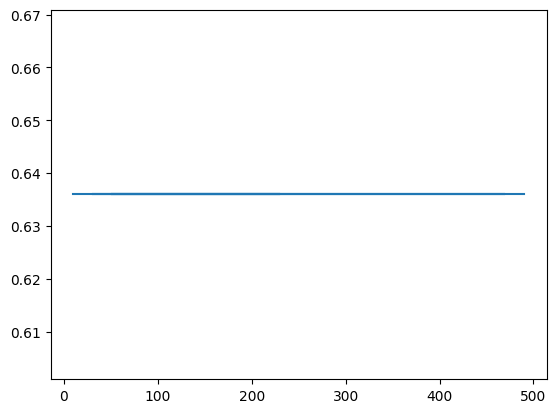

In [328]:
plt.plot(models.model, models.score_val)

In [ ]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1,
                                    n_jobs = -1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [ ]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [ ]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

In [ ]:
max_depth = 15

In [ ]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1,
                                    n_jobs = 6)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [ ]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [ ]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [ ]:
min_samples_leaf = 10

In [ ]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1,
                            n_jobs=6)
rf.fit(X_train, y_train)

In [ ]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

In [329]:
from sklearn.model_selection import RandomizedSearchCV

# Create the random grid
random_grid = {
            'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
            'max_features': ['auto', 'sqrt'],
            'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            }

In [330]:
rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 100,
                               cv = 3,
                               verbose=2,
                               random_state=1,
                               n_jobs = 8)

In [331]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` h

[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time= 1.7min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1800; total time= 2.0min
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1600; total time= 1.6min
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  22.1s
[CV] END max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=  18.7s
[CV] END max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  21.3s
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time= 1.6min


/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time= 3.8min
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1600; total time= 1.7min
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  26.4s
[CV] END max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  27.1s
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time= 1.7min


/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` h

[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  23.4s
[CV] END max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time= 1.4min
[CV] END max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total time= 3.7min
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  21.0s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  19.7s
[CV] END max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time= 1.6min
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time= 1.8min
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=  48.7s
[CV] END max_depth=70, max_fe

/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` h

[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time= 1.9min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time= 3.0min
[CV] END max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time= 1.6min
[CV] END max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time= 3.7min
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time= 1.6min
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=  45.3s
[CV] END max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time= 4.0min
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time= 1.9min
[CV] END max_depth=50, max_featu

/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time= 1.3min
[CV] END max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time= 3.8min


/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time= 1.4min
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time= 1.5min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time= 2.9min
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time= 1.2min
[CV] END max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time= 3.6min
[CV] END max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time= 3.8min
[CV] END max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time= 3.6min
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time= 1.2min
[CV] END max_depth=70, max_featu

/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time= 3.8min
[CV] END max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time= 1.7min
[CV] END max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=  19.1s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time= 1.3min
[CV] END max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time= 1.4min
[CV] END max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time= 1.4min
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time= 1.8min
[CV] END max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time= 4.0min
[CV] END max_depth=70, max_fea

/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` h

[CV] END max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1200; total time= 2.3min
[CV] END max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time= 1.5min


/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` h

[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time= 1.7min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1800; total time= 1.9min
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1600; total time= 1.8min
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  22.8s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time= 1.3min
[CV] END max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time= 1.5min
[CV] END max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total time= 3.8min
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=  49.3s
[CV] END max_depth=50, max_feature

/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` h

[CV] END max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1800; total time= 3.7min
[CV] END max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1400; total time= 2.8min
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  26.3s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  22.9s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=  37.9s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=  40.2s
[CV] END max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time= 3.8min
[CV] END max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time= 3.9min
[CV] END max_depth=50, max_fea

/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` h

[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=  37.6s
[CV] END max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time= 3.3min
[CV] END max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1200; total time= 2.5min
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time= 1.4min
[CV] END max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time= 1.4min
[CV] END max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  57.1s
[CV] END max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=  59.8s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1800; total time= 3.3min


/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` h

[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1600; total time= 2.9min
[CV] END max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  26.9s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  21.7s
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time= 1.7min
[CV] END max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=  44.0s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time= 1.4min
[CV] END max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time= 1.4min
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time= 1.7min
[CV] END max_depth=10, max_features=s

/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` h

[CV] END max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time= 2.8min
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time= 3.4min


/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` h

[CV] END max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time= 2.0min
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time= 2.1min
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time= 1.7min
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time= 3.9min


/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time= 1.4min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1800; total time= 1.8min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time= 2.9min
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time= 1.7min
[CV] END max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time= 1.4min
[CV] END max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total time= 3.8min
[CV] END max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time= 4.1min
[CV] END max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1800; total time= 3.9min
[CV] END max_depth=110, max_feat

/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` h

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=8,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=1, verbose=2)

In [332]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 80}

In [336]:
rf = RandomForestClassifier(n_estimators = 600,
                            min_samples_split= 10,
                            min_samples_leaf= 4,
                            max_features='sqrt',
                            max_depth=80,
                            random_state = 1,
                            n_jobs = 10)
rf.fit(X_train, y_train)

# get score on train
y_pred = lr.predict_proba(X_train)[:, 1]
score_train = roc_auc_score(y_train, y_pred)

# get score on train
y_pred = lr.predict_proba(X_val)[:, 1]
score_val = roc_auc_score(y_val, y_pred)

[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time= 1.5min
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  27.4s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=  37.2s
[CV] END max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time= 4.1min
[CV] END max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time= 1.7min
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time=  40.1s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time= 1.1min
[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=  56.4s
[CV] END max_depth=20, max_features=

[CV] END max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1800; total time= 3.5min
[CV] END max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time= 1.2min
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time= 1.6min
[CV] END max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time= 4.2min
[CV] END max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time= 1.4min
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=  56.2s
[CV] END max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time= 4.1min
[CV] END max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=  48.4s
[CV] END max_depth=50, max_feature

In [338]:
score_train, score_val

(0.6531268922625739, 0.6359661143791073)

### D.5.1 XGBoost

In [340]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [342]:
key = 'eta'
params = np.arange(0.1, 0.51, 0.025)
models = pd.DataFrame(columns = [key,'score_train', 'score_val'])

for param in params:
    xgb_params = {
                'eta': param, 
                'max_depth': 6,
                'min_child_weight': 1,

                'objective': 'binary:logistic',
                'nthread': 8,

                'seed': 1,
                'verbosity': 1,
                }
    
    xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=200)
    
    # get score on train
    y_pred = xgb_model.predict(dtrain)
    score_train = roc_auc_score(y_train, y_pred)
    
    # get score on train
    y_pred = xgb_model.predict(dval)
    score_val = roc_auc_score(y_val, y_pred)
    
    app_list = [param, score_train, score_val]

    models.loc[len(models)] = app_list
    

models = models.sort_values(by=['score_val'], ascending = False)

,eta,score_train,score_val
0,0.100,0.849651,0.620438
2,0.150,0.890393,0.617638
1,0.125,0.873866,0.616077
4,0.200,0.913308,0.609568
5,0.225,0.921821,0.608351


In [344]:
models[:10]

,eta,score_train,score_val
0,0.100,0.849651,0.620438
2,0.150,0.890393,0.617638
1,0.125,0.873866,0.616077
4,0.200,0.913308,0.609568
5,0.225,0.921821,0.608351
3,0.175,0.903556,0.608060
7,0.275,0.938205,0.606434
6,0.250,0.930838,0.605484
8,0.300,0.945604,0.600254
10,0.350,0.947649,0.596958


In [343]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [348]:
scores = {}
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [359]:
%%capture output

xgb_params = {
    'eta': 0.500, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [360]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.5'

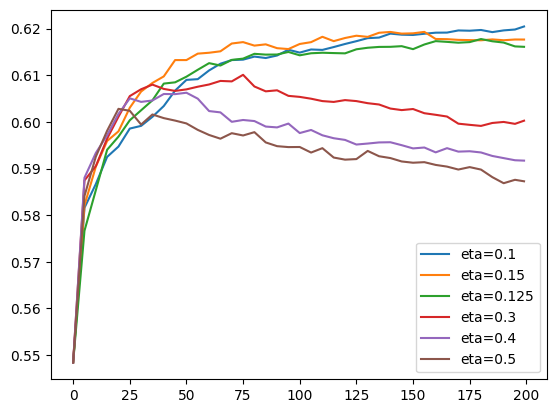

In [362]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

#plt.ylim(0.8, 0.84)
plt.legend()

Based from the plot, even if 0.1 has the highest scores in the end, we still select 0.15 because it leads 0.1 until around 130 rounds and it's scores is not that far with 0.1

In [363]:
best_eta = 0.15

In [366]:
models = pd.DataFrame(columns = ['max_depth', 'min_child_weight', 'score_train', 'score_val'])

for d in range(1,11):
    for w in range(1,11):
        xgb_params = {
                    'eta': best_eta, 
                    'max_depth': d,
                    'min_child_weight': w,

                    'objective': 'binary:logistic',
                    'nthread': 8,

                    'seed': 1,
                    'verbosity': 1,
                    }

        xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=200)

        # get score on train
        y_pred = xgb_model.predict(dtrain)
        score_train = roc_auc_score(y_train, y_pred)

        # get score on train
        y_pred = xgb_model.predict(dval)
        score_val = roc_auc_score(y_val, y_pred)

        app_list = [d, w, score_train, score_val]

        models.loc[len(models)] = app_list

models = models.sort_values(by=['score_val'], ascending = False)
models[:5]

,max_depth,min_child_weight,score_train,score_val
26,3.0,7.0,0.705645,0.628824
31,4.0,2.0,0.761782,0.628046
22,3.0,3.0,0.709866,0.627504
27,3.0,8.0,0.704304,0.627418
24,3.0,5.0,0.707297,0.627211


In [374]:
tuned_score = pd.DataFrame(columns = [key,'score_train', 'score_val'])

tuned_lr = ['tuned_lr', 0.6523, 0.6365]
tuned_dt = ['tuned_dt', 0.6260, 0.5567]
tuned_rf = ['tuned_dt', 0.6531, 0.6360]
tuned_xgb = ['tuned_xgb', 0.7056, 0.6288]

tuned_score.loc[len(tuned_score)] = tuned_lr
tuned_score.loc[len(tuned_score)] = tuned_dt
tuned_score.loc[len(tuned_score)] = tuned_rf
tuned_score.loc[len(tuned_score)] = tuned_xgb

### Selecting the best model

In [375]:
tuned_score

,eta=0.5,score_train,score_val
0,tuned_lr,0.6523,0.6365
1,tuned_dt,0.6260,0.5567
2,tuned_dt,0.6531,0.6360
3,tuned_xgb,0.7056,0.6288


In [376]:
base_score

,model,score_train,score_val
0,logistic regression,0.65235,0.636533
1,decision_tree,1.00000,0.514576
2,random forest,1.00000,0.605088
3,xgboost,0.68707,0.590079


We will try the base logistic regression, tuned_dt, and tuned_xgb on the test datasets

In [610]:
models = pd.DataFrame(columns = ['model', 'score_fulltrain', 'score_test'])

In [612]:
df_fulltrain = df_full_train.reset_index(drop=True)
y_fulltrain = y_full_train

In [613]:
dv = DictVectorizer(sparse=False)

dicts_full_train = df_full_train.to_dict(orient='records')
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [614]:
mod = 'logistic regression'
lr = LogisticRegression(random_state=1)

lr.fit(X_full_train, y_fulltrain)

# get score on train
y_pred = lr.predict_proba(X_full_train)[:, 1]
score_fulltrain = roc_auc_score(y_fulltrain, y_pred)

# get score on train
y_pred = lr.predict_proba(X_test)[:, 1]
score_test = roc_auc_score(y_test, y_pred)

app_list = [mod, score_fulltrain, score_test]

models.loc[len(models)] = app_list

/home/chanchan/Documents/data_projects/ml_zoomcamp/capstone_midterm/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [615]:
models

,model,score_fulltrain,score_test
0,logistic regression,0.651142,0.637286


In [572]:
dt_random.best_params_

{'min_samples_leaf': 100, 'max_depth': 20, 'criterion': 'entropy'}

In [573]:
mod = 'Decision Tree'
dt = DecisionTreeClassifier(min_samples_leaf=100, 
                            max_depth=20, 
                            criterion='entropy')

dt.fit(X_full_train, y_fulltrain)

# get score on train
y_pred = dt.predict_proba(X_full_train)[:, 1]
score_fulltrain = roc_auc_score(y_fulltrain, y_pred)

# get score on train
y_pred = dt.predict_proba(X_test)[:, 1]
score_test = roc_auc_score(y_test, y_pred)

app_list = [mod, score_fulltrain, score_test]

models.loc[len(models)] = app_list

In [574]:
models

,model,score_fulltrain,score_test
0,logistic regression,1.0,0.631915
1,Decision Tree,1.0,0.500000


tuned xgboost: eta = 0.15, max_depth=3, min_child_weight=6

In [656]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [657]:
df_full_train = df_full_train.reset_index(drop=True)
y_full_train = df_full_train['radiant_win'].astype(int).values

del df_full_train['radiant_win']

dv = DictVectorizer(sparse=False)

dicts_full_train = df_full_train.to_dict(orient='records')
X_full_train = dv.fit_transform(dicts_full_train)

dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train)
dtest = xgb.DMatrix(X_full_train, label=y_full_train)

In [658]:
mod = 'xgb'

xgb_params = {
    'eta': 0.2, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

xgmodel = xgb.train(xgb_params, dfulltrain, num_boost_round=200)

In [659]:
# get score on train
y_pred = model.predict(dfulltrain)
score_fulltrain = roc_auc_score(y_fulltrain, y_pred)

# get score on train
y_pred = model.predict(dtest)
score_test = roc_auc_score(y_test, y_pred)

app_list = [mod, score_fulltrain, score_test]

models.loc[len(models)] = app_list

In [660]:
models

,model,score_fulltrain,score_test
0,logistic regression,0.651142,0.637286
1,logistic regression,0.710476,0.710476
2,xgb,0.710476,0.710476


## Using the chosen model

In [664]:
model = pd.DataFrame(['model','score_train','score_test'])

In [662]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [663]:
df_full_train = df_full_train.reset_index(drop=True)
y_full_train = df_full_train['radiant_win'].astype(int).values
df_test = df_test.reset_index(drop=True)
y_test = df_test['radiant_win'].astype(int).values

del df_full_train['radiant_win']
del df_test['radiant_win']

dv = DictVectorizer(sparse=False)

dicts_full_train = df_full_train.to_dict(orient='records')
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.fit_transform(dicts_test)

dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [665]:
mod = 'xgb'

xgb_params = {
    'eta': 0.2, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

xgmodel = xgb.train(xgb_params, dfulltrain, num_boost_round=200)

In [667]:
# get score on train
y_pred = xgmodel.predict(dfulltrain)
score_fulltrain = roc_auc_score(y_fulltrain, y_pred)

# get score on train
y_pred = xgmodel.predict(dtest)
score_test = roc_auc_score(y_test, y_pred)

app_list = [mod, score_fulltrain, score_test]

models.loc[len(models)] = app_list

In [668]:
roc_auc_score(y_test, y_pred)

0.6264083302816822

## Saving the chosen model

In [ ]:
import bentoml

In [650]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [651]:
df_full_train = df_full_train.reset_index(drop=True)
y_full_train = df_full_train['radiant_win'].astype(int).values

del df_full_train['radiant_win']

In [652]:
dv = DictVectorizer(sparse=False)

dicts_full_train = df_full_train.to_dict(orient='records')
X_full_train = dv.fit_transform(dicts_full_train)

In [653]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train)
dtest = xgb.DMatrix(X_full_train, label=y_full_train)

In [ ]:
xgb_params = {
    'eta': 0.2, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

xgmodel = xgb.train(xgb_params, dfulltrain, num_boost_round=200)

In [ ]:
bentoml.xgboost.save_model(
    'dota2_predictor_model',
    xgmodel,
    custom_objects={
        'dictVectorizer': dv
    })